# Comparison with other libraries

This notebooks extends 'evobandits_demo.ipynb' to compare the GMAB algorithm with popular alternatives.

Note that running this notebook can take very long (multiple days!) due to the number of algorithms, independent runs, and simulation cost.

Setup:

In [1]:
import json
from pathlib import Path

from evobandits import CategoricalParam, Study, GMAB
from irace import irace, Experiment, ParameterSpace, Scenario, Ordinal
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler, RandomSampler
from optuna.pruners import HyperbandPruner
from tqdm import tqdm

c:\Users\fwuer\Code\evobandits-demo\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from application_example import genetic_algorithm

In [3]:
plt.style.use("default")

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = [
    "Computer Modern Roman",
    "Times New Roman",
    "Times",
    "DejaVu Serif",
]
mpl.rcParams["font.size"] = 14

optuna.logging.set_verbosity(optuna.logging.WARNING) # to suppress log spam

## 1. Presets for the Optimization

Identical number of runs, budget and a seed for reproduction:

In [4]:
SEED = 42
N_RUNS = 50
SIM_BUDGET = 1000
EVAL_BUDGET = 500

All variables are modeled as ordinal variables from the ranges below to ensure identical search space.

In [5]:
POP_SIZE_RANGE = [i for i in range(50, 251, 1)]
GENERATIONS_RANGE = [100, 200, 300, 400, 500]
ELITE_SPLIT_RANGE = [i * 0.01 for i in range(21)]
TOURNAMENT_SPLIT_RANGE = [i * 0.01 for i in range(11)]
CROSSOVER_RATE_RANGE = [i * 0.01 for i in range(101)]
MUTATION_RATE_RANGE = [i * 0.01 for i in range(101)]

Size of the Search space

In [6]:
total_combinations = len(POP_SIZE_RANGE) * len(ELITE_SPLIT_RANGE) * len(GENERATIONS_RANGE) \
    * len(TOURNAMENT_SPLIT_RANGE) * len(CROSSOVER_RATE_RANGE) * len(MUTATION_RATE_RANGE)

print(f"Number of distinct solutions:\t{total_combinations:,}")

Number of distinct solutions:	2,368,213,155


## 2. Optimization

For each algorithm:
- Model the genetic_algorithm as objective function
- Model the search space
- Configure the algorithm
- Execute for preset, identical budget and runs
- Collect the results and re-sample to evaluate the "true" value of the configuration.

In [7]:
def estimate_true_value(seed, ga_configuration):
    evaluations = []
    rng = np.random.default_rng(seed)
    for _ in range(EVAL_BUDGET):
        seed_eval = rng.integers(0, 2**32 - 1, dtype=int)
        best_cost, _ = genetic_algorithm(seed=seed_eval, **ga_configuration)
        evaluations.append(best_cost)
    mean_evaluation = np.mean(evaluations)
    return mean_evaluation, evaluations

### 2.1 EvoBandits

In [8]:
def objective(seed: int, **params: dict):
    """Seeded, single-objective function to simulate the GA."""
    best_cost, _ = genetic_algorithm(seed=seed, **params)
    return best_cost

params = {
    "pop_size": CategoricalParam(POP_SIZE_RANGE),
    "generations": CategoricalParam(GENERATIONS_RANGE),
    "elite_split": CategoricalParam(ELITE_SPLIT_RANGE), 
    "tournament_split": CategoricalParam(TOURNAMENT_SPLIT_RANGE),
    "mutation_rate": CategoricalParam(MUTATION_RATE_RANGE), 
    "crossover_rate": CategoricalParam(CROSSOVER_RATE_RANGE), 
}

print("\nRunning optimization ...")
results_evobandits = []

for run_id in tqdm(range(N_RUNS), desc="EvoBandits | Run"):
    seed = SEED + run_id
    gmab = GMAB(population_size=10)
    study = Study(seed=seed, algorithm=gmab)
    study.optimize(objective, params, n_trials=SIM_BUDGET)
    print(f"Config:\t{study.best_params}")
    print(f"Value:\t{study.best_value}")

    mean_evaluation, evaluations = estimate_true_value(seed, study.best_params)
    print(f"Est. true value:\t{mean_evaluation}")

    results_evobandits.append({
        "mean_evaluation": mean_evaluation,
        "evaluations": evaluations,
        "best_solution": study.best_solution,
        "seed": seed
    })

    with open(Path("_data/04_results_evobandits.json"), 'w') as f:
        json.dump(results_evobandits, f)


Running optimization ...


EvoBandits | Run:   0%|          | 0/50 [00:00<?, ?it/s]

Config:	{'pop_size': 226, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.05, 'mutation_rate': 0.78, 'crossover_rate': 0.0}
Value:	7.925576596461831


EvoBandits | Run:   2%|▏         | 1/50 [1:31:11<74:28:22, 5471.48s/it]

Est. true value:	8.009099365950854
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.04, 'mutation_rate': 0.84, 'crossover_rate': 0.0}
Value:	7.866737136573285


EvoBandits | Run:   4%|▍         | 2/50 [3:04:55<74:08:54, 5561.14s/it]

Est. true value:	7.985106184692074
Config:	{'pop_size': 250, 'generations': 400, 'elite_split': 0.16, 'tournament_split': 0.09, 'mutation_rate': 0.84, 'crossover_rate': 0.25}
Value:	7.9950112647249405


EvoBandits | Run:   6%|▌         | 3/50 [4:21:24<66:48:40, 5117.45s/it]

Est. true value:	8.111970052316993
Config:	{'pop_size': 240, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.05, 'mutation_rate': 0.79, 'crossover_rate': 0.0}
Value:	7.797543215107326


EvoBandits | Run:   8%|▊         | 4/50 [5:49:30<66:14:19, 5183.89s/it]

Est. true value:	7.987494340327031
Config:	{'pop_size': 247, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.05, 'mutation_rate': 0.88, 'crossover_rate': 0.02}
Value:	7.873475842560513


EvoBandits | Run:  10%|█         | 5/50 [7:25:36<67:25:24, 5393.88s/it]

Est. true value:	7.962507188256683
Config:	{'pop_size': 250, 'generations': 400, 'elite_split': 0.03, 'tournament_split': 0.1, 'mutation_rate': 0.8200000000000001, 'crossover_rate': 0.09}
Value:	7.926533679546161


EvoBandits | Run:  12%|█▏        | 6/50 [8:50:36<64:42:02, 5293.70s/it]

Est. true value:	8.014330661207499
Config:	{'pop_size': 246, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.09, 'mutation_rate': 0.9400000000000001, 'crossover_rate': 0.0}
Value:	7.865673725781605


EvoBandits | Run:  14%|█▍        | 7/50 [10:20:52<63:42:30, 5333.74s/it]

Est. true value:	7.9471121037165195
Config:	{'pop_size': 249, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.08, 'mutation_rate': 0.64, 'crossover_rate': 0.1}
Value:	7.860782956726181


EvoBandits | Run:  16%|█▌        | 8/50 [11:53:36<63:04:53, 5406.98s/it]

Est. true value:	8.03600209409043
Config:	{'pop_size': 230, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.1, 'mutation_rate': 0.97, 'crossover_rate': 0.0}
Value:	7.801173563105813


EvoBandits | Run:  18%|█▊        | 9/50 [13:16:14<59:58:56, 5266.74s/it]

Est. true value:	7.927656322194829
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'mutation_rate': 0.51, 'crossover_rate': 0.08}
Value:	7.919504538713044


EvoBandits | Run:  20%|██        | 10/50 [14:50:55<59:56:23, 5394.58s/it]

Est. true value:	8.008776573938981
Config:	{'pop_size': 245, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.1, 'mutation_rate': 0.65, 'crossover_rate': 0.0}
Value:	7.877796473373995


EvoBandits | Run:  22%|██▏       | 11/50 [16:20:38<58:24:12, 5391.08s/it]

Est. true value:	8.012169910420436
Config:	{'pop_size': 209, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'mutation_rate': 0.53, 'crossover_rate': 0.18}
Value:	7.9870913710800835


EvoBandits | Run:  24%|██▍       | 12/50 [17:33:04<53:33:02, 5073.23s/it]

Est. true value:	8.118224861010377
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.04, 'mutation_rate': 0.87, 'crossover_rate': 0.0}
Value:	7.886763863887318


EvoBandits | Run:  26%|██▌       | 13/50 [19:12:18<54:53:04, 5340.12s/it]

Est. true value:	7.989813157168992
Config:	{'pop_size': 217, 'generations': 400, 'elite_split': 0.0, 'tournament_split': 0.08, 'mutation_rate': 0.68, 'crossover_rate': 0.02}
Value:	8.011979728394396


EvoBandits | Run:  28%|██▊       | 14/50 [20:21:33<49:49:12, 4982.02s/it]

Est. true value:	8.067574052541332
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.07, 'mutation_rate': 0.75, 'crossover_rate': 0.0}
Value:	7.824910948289569


EvoBandits | Run:  30%|███       | 15/50 [21:53:27<49:59:43, 5142.37s/it]

Est. true value:	7.9741605664183774
Config:	{'pop_size': 208, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.1, 'mutation_rate': 0.93, 'crossover_rate': 0.08}
Value:	7.848482230823225


EvoBandits | Run:  32%|███▏      | 16/50 [23:13:09<47:32:31, 5033.86s/it]

Est. true value:	7.9887860900549965
Config:	{'pop_size': 238, 'generations': 400, 'elite_split': 0.08, 'tournament_split': 0.09, 'mutation_rate': 0.74, 'crossover_rate': 0.0}
Value:	7.8270375503905925


EvoBandits | Run:  34%|███▍      | 17/50 [24:27:27<44:33:25, 4860.76s/it]

Est. true value:	8.040487346341546
Config:	{'pop_size': 244, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.07, 'mutation_rate': 0.85, 'crossover_rate': 0.02}
Value:	7.79025969877992


EvoBandits | Run:  36%|███▌      | 18/50 [25:53:32<44:01:13, 4952.31s/it]

Est. true value:	7.979860433199059
Config:	{'pop_size': 237, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.09, 'mutation_rate': 0.81, 'crossover_rate': 0.0}
Value:	7.83209337122758


EvoBandits | Run:  38%|███▊      | 19/50 [27:20:13<43:17:09, 5026.75s/it]

Est. true value:	7.9918696217563285
Config:	{'pop_size': 209, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.07, 'mutation_rate': 0.89, 'crossover_rate': 0.07}
Value:	7.788137505855329


EvoBandits | Run:  40%|████      | 20/50 [28:34:57<40:31:56, 4863.87s/it]

Est. true value:	8.008133743096735
Config:	{'pop_size': 204, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.09, 'mutation_rate': 0.78, 'crossover_rate': 0.0}
Value:	7.8830218710724775


EvoBandits | Run:  42%|████▏     | 21/50 [29:45:59<37:43:38, 4683.40s/it]

Est. true value:	7.992215678397155
Config:	{'pop_size': 230, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.07, 'mutation_rate': 0.77, 'crossover_rate': 0.12}
Value:	7.795488840494284


EvoBandits | Run:  44%|████▍     | 22/50 [31:21:30<38:52:14, 4997.65s/it]

Est. true value:	7.999035405321987
Config:	{'pop_size': 237, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.09, 'mutation_rate': 0.86, 'crossover_rate': 0.07}
Value:	7.882302257973967


EvoBandits | Run:  46%|████▌     | 23/50 [32:46:48<37:45:14, 5033.85s/it]

Est. true value:	7.998569049969694
Config:	{'pop_size': 247, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.07, 'mutation_rate': 0.87, 'crossover_rate': 0.1}
Value:	7.930990198829469


EvoBandits | Run:  48%|████▊     | 24/50 [34:23:42<38:02:46, 5267.94s/it]

Est. true value:	7.982644502521114
Config:	{'pop_size': 238, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.09, 'mutation_rate': 0.8, 'crossover_rate': 0.0}
Value:	7.862777287603436


EvoBandits | Run:  50%|█████     | 25/50 [35:50:05<36:24:20, 5242.41s/it]

Est. true value:	7.9898043437455675
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.08, 'mutation_rate': 0.74, 'crossover_rate': 0.24}
Value:	7.912733416385374


EvoBandits | Run:  52%|█████▏    | 26/50 [37:27:48<36:11:29, 5428.72s/it]

Est. true value:	8.01352651527818
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.05, 'mutation_rate': 0.58, 'crossover_rate': 0.0}
Value:	7.895665217083467


EvoBandits | Run:  54%|█████▍    | 27/50 [38:44:28<33:05:40, 5180.02s/it]

Est. true value:	8.036065454217574
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.1, 'mutation_rate': 1.0, 'crossover_rate': 0.02}
Value:	7.693996008983231


EvoBandits | Run:  56%|█████▌    | 28/50 [40:28:14<33:34:20, 5493.68s/it]

Est. true value:	7.882097418500807
Config:	{'pop_size': 195, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.09, 'mutation_rate': 0.9, 'crossover_rate': 0.04}
Value:	7.876510749387142


EvoBandits | Run:  58%|█████▊    | 29/50 [41:29:10<28:49:50, 4942.40s/it]

Est. true value:	7.989801381824106
Config:	{'pop_size': 223, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.07, 'mutation_rate': 0.75, 'crossover_rate': 0.07}
Value:	7.901679158250727


EvoBandits | Run:  60%|██████    | 30/50 [42:53:17<27:37:56, 4973.80s/it]

Est. true value:	8.009519578170192
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.08, 'mutation_rate': 0.98, 'crossover_rate': 0.02}
Value:	7.8910710093626495


EvoBandits | Run:  62%|██████▏   | 31/50 [44:37:19<28:15:31, 5354.31s/it]

Est. true value:	7.915831150860409
Config:	{'pop_size': 249, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.08, 'mutation_rate': 0.9500000000000001, 'crossover_rate': 0.07}
Value:	7.706146049468488


EvoBandits | Run:  64%|██████▍   | 32/50 [46:05:50<26:42:24, 5341.34s/it]

Est. true value:	7.962662545737854
Config:	{'pop_size': 232, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.05, 'mutation_rate': 0.84, 'crossover_rate': 0.0}
Value:	7.909073910116425


EvoBandits | Run:  66%|██████▌   | 33/50 [47:21:07<24:03:18, 5094.05s/it]

Est. true value:	7.986558219166682
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.06, 'mutation_rate': 0.76, 'crossover_rate': 0.05}
Value:	7.753453370360533


EvoBandits | Run:  68%|██████▊   | 34/50 [48:53:56<23:16:25, 5236.61s/it]

Est. true value:	7.981881924950611
Config:	{'pop_size': 247, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.04, 'mutation_rate': 0.7000000000000001, 'crossover_rate': 0.0}
Value:	7.938918175605826


EvoBandits | Run:  70%|███████   | 35/50 [50:30:43<22:31:52, 5407.50s/it]

Est. true value:	8.018775323236934
Config:	{'pop_size': 206, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.1, 'mutation_rate': 0.79, 'crossover_rate': 0.14}
Value:	7.911933194917084


EvoBandits | Run:  72%|███████▏  | 36/50 [51:46:38<20:02:06, 5151.90s/it]

Est. true value:	7.999369269702338
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.07, 'mutation_rate': 0.75, 'crossover_rate': 0.15}
Value:	7.8882286485359785


EvoBandits | Run:  74%|███████▍  | 37/50 [53:22:50<19:16:34, 5338.01s/it]

Est. true value:	7.985251880657744
Config:	{'pop_size': 239, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.1, 'mutation_rate': 0.98, 'crossover_rate': 0.24}
Value:	7.89336568764409


EvoBandits | Run:  76%|███████▌  | 38/50 [55:10:55<18:56:22, 5681.90s/it]

Est. true value:	7.968185634893144
Config:	{'pop_size': 225, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.06, 'mutation_rate': 0.81, 'crossover_rate': 0.08}
Value:	7.890599347778869


EvoBandits | Run:  78%|███████▊  | 39/50 [56:25:16<16:14:32, 5315.64s/it]

Est. true value:	7.987022223414517
Config:	{'pop_size': 247, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'mutation_rate': 0.8, 'crossover_rate': 0.0}
Value:	7.890026695976286


EvoBandits | Run:  80%|████████  | 40/50 [58:12:16<15:41:09, 5646.95s/it]

Est. true value:	7.974329877225645
Config:	{'pop_size': 250, 'generations': 400, 'elite_split': 0.2, 'tournament_split': 0.09, 'mutation_rate': 0.81, 'crossover_rate': 0.0}
Value:	7.927989017286298


EvoBandits | Run:  82%|████████▏ | 41/50 [59:24:02<13:06:43, 5244.86s/it]

Est. true value:	8.030080284244177
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.05, 'mutation_rate': 0.65, 'crossover_rate': 0.0}
Value:	7.875789725364237


EvoBandits | Run:  84%|████████▍ | 42/50 [60:57:01<11:52:40, 5345.01s/it]

Est. true value:	7.986542463409997
Config:	{'pop_size': 200, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.06, 'mutation_rate': 0.75, 'crossover_rate': 0.01}
Value:	7.85948347105605


EvoBandits | Run:  86%|████████▌ | 43/50 [62:03:52<9:36:52, 4944.68s/it] 

Est. true value:	8.036028811322327
Config:	{'pop_size': 229, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.08, 'mutation_rate': 0.63, 'crossover_rate': 0.06}
Value:	7.861662036496136


EvoBandits | Run:  88%|████████▊ | 44/50 [63:33:19<8:27:08, 5071.36s/it]

Est. true value:	8.020267742945215
Config:	{'pop_size': 209, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.07, 'mutation_rate': 0.9400000000000001, 'crossover_rate': 0.0}
Value:	7.846357529578726


EvoBandits | Run:  90%|█████████ | 45/50 [64:50:49<6:52:04, 4944.90s/it]

Est. true value:	7.982574206573523
Config:	{'pop_size': 209, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.09, 'mutation_rate': 0.54, 'crossover_rate': 0.01}
Value:	7.896837829998442


EvoBandits | Run:  92%|█████████▏| 46/50 [66:05:01<5:19:48, 4797.10s/it]

Est. true value:	8.03635308957322
Config:	{'pop_size': 232, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.07, 'mutation_rate': 0.54, 'crossover_rate': 0.04}
Value:	7.818947143584331


EvoBandits | Run:  94%|█████████▍| 47/50 [67:38:19<4:11:52, 5037.44s/it]

Est. true value:	8.03253549623815
Config:	{'pop_size': 250, 'generations': 400, 'elite_split': 0.11, 'tournament_split': 0.07, 'mutation_rate': 0.9500000000000001, 'crossover_rate': 0.0}
Value:	7.903605700234994


EvoBandits | Run:  96%|█████████▌| 48/50 [68:57:21<2:44:57, 4948.90s/it]

Est. true value:	8.059633556200282
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.07, 'mutation_rate': 0.84, 'crossover_rate': 0.0}
Value:	7.8601310346791795


EvoBandits | Run:  98%|█████████▊| 49/50 [70:27:49<1:24:52, 5092.49s/it]

Est. true value:	7.984837240667651
Config:	{'pop_size': 234, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.08, 'mutation_rate': 0.8, 'crossover_rate': 0.13}
Value:	7.903063362310793


EvoBandits | Run: 100%|██████████| 50/50 [71:51:50<00:00, 5174.22s/it]  

Est. true value:	7.997906602060502


### 2.2 IRACE

In [9]:
def ga_runner(experiment: Experiment, scenario: Scenario):
    """Seeded, single-objective function to simulate the GA with irace."""
    best_cost, _ = genetic_algorithm(
        seed=experiment.seed, **experiment.configuration
    )
    return float(best_cost)

param_space = ParameterSpace(
    [
        Ordinal("pop_size", POP_SIZE_RANGE),
        Ordinal("generations", GENERATIONS_RANGE),
        Ordinal("elite_split", ELITE_SPLIT_RANGE),
        Ordinal("tournament_split", TOURNAMENT_SPLIT_RANGE),
        Ordinal("crossover_rate", CROSSOVER_RATE_RANGE),
        Ordinal("mutation_rate", MUTATION_RATE_RANGE),
    ]
)

print("\nRunning optimization ...")
results_irace = []

for run_id in tqdm(range(N_RUNS), desc="IRACE | Run"):
    print("\nRunning optimization ...")
    seed = SEED + run_id
    scenario = Scenario(
        max_experiments=SIM_BUDGET,
        verbose=0,
    )
    best_params = irace(ga_runner, param_space, scenario)[0]
    print(f"Config:\t{best_params}")

    mean_evaluation, evaluations = estimate_true_value(seed, best_params)
    print(f"Est. true value:\t{mean_evaluation}")

    results_irace.append({
        "mean_evaluation": mean_evaluation,
        "evaluations": evaluations,
        "best_params": best_params,
        "seed": seed,
    })

    with open(Path("_data/04_results_irace.json"), 'w') as f:
        json.dump(results_irace, f)


Running optimization ...


IRACE | Run:   0%|          | 0/50 [00:00<?, ?it/s]


Running optimization ...


Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.
c:\Users\fwuer\Code\evobandits-demo\.venv\Lib\site-packages\rpy2\rinterface\__init__.py:1211: UserWarning: Environment variable "PATH" redefined by R and overriding existing variable. Current: "c:\Users\fwuer\Code\evobandits-demo\.venv\Scripts;C:\Program Files (x86)\Intel\iCLS Client\;C:\Program Files\Intel\iCLS Client\;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\DAL;C:\Program Files\Intel\Intel(R) Management Engine Components\DAL;C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\IPT;C:\Program Files\Intel\Intel(R) Management Engine Components\IPT;C:\Program Files\Intel\WiFi\bin\;C:\Program Files\Common Files\Intel\WirelessCommon\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Git\cmd;C:\Users\fwuer\AppData\Local\Programs\Python\Launc

Config:	OrderedDict({'pop_size': 199, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.09, 'crossover_rate': 0.08, 'mutation_rate': 0.96})


IRACE | Run:   2%|▏         | 1/50 [57:38<47:04:17, 3458.32s/it]

Est. true value:	8.004072794238738

Running optimization ...
Config:	OrderedDict({'pop_size': 186, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.08, 'crossover_rate': 0.01, 'mutation_rate': 0.84})


IRACE | Run:   4%|▍         | 2/50 [1:48:37<42:59:02, 3223.79s/it]

Est. true value:	8.05216708562738

Running optimization ...
Config:	OrderedDict({'pop_size': 231, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.07, 'crossover_rate': 0.25, 'mutation_rate': 0.92})


IRACE | Run:   6%|▌         | 3/50 [2:56:48<47:15:16, 3619.51s/it]

Est. true value:	8.031273803417456

Running optimization ...
Config:	OrderedDict({'pop_size': 239, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.1, 'crossover_rate': 0.09, 'mutation_rate': 0.91})


IRACE | Run:   8%|▊         | 4/50 [4:13:47<51:17:29, 4014.13s/it]

Est. true value:	7.95148684778089

Running optimization ...
Config:	OrderedDict({'pop_size': 234, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.09, 'crossover_rate': 0.04, 'mutation_rate': 0.91})


IRACE | Run:  10%|█         | 5/50 [5:23:30<50:56:19, 4075.10s/it]

Est. true value:	7.99988265748262

Running optimization ...
Config:	OrderedDict({'pop_size': 246, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.1, 'crossover_rate': 0.02, 'mutation_rate': 0.42})


IRACE | Run:  12%|█▏        | 6/50 [6:27:43<48:52:59, 3999.54s/it]

Est. true value:	8.088061893715068

Running optimization ...
Config:	OrderedDict({'pop_size': 220, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.1, 'crossover_rate': 0.08, 'mutation_rate': 0.8})


IRACE | Run:  14%|█▍        | 7/50 [7:29:20<46:35:26, 3900.61s/it]

Est. true value:	8.00135788671384

Running optimization ...
Config:	OrderedDict({'pop_size': 224, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.1, 'crossover_rate': 0.31, 'mutation_rate': 0.9400000000000001})


IRACE | Run:  16%|█▌        | 8/50 [8:41:03<47:00:05, 4028.69s/it]

Est. true value:	8.018989347888024

Running optimization ...
Config:	OrderedDict({'pop_size': 189, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.1, 'crossover_rate': 0.04, 'mutation_rate': 0.37})


IRACE | Run:  18%|█▊        | 9/50 [9:32:28<42:31:22, 3733.71s/it]

Est. true value:	8.219177658881737

Running optimization ...
Config:	OrderedDict({'pop_size': 233, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.08, 'crossover_rate': 0.16, 'mutation_rate': 0.61})


IRACE | Run:  20%|██        | 10/50 [10:35:40<41:41:11, 3751.78s/it]

Est. true value:	8.02562543390154

Running optimization ...
Config:	OrderedDict({'pop_size': 185, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.08, 'crossover_rate': 0.16, 'mutation_rate': 0.55})


IRACE | Run:  22%|██▏       | 11/50 [11:28:29<38:42:36, 3573.25s/it]

Est. true value:	8.146476638833853

Running optimization ...
Config:	OrderedDict({'pop_size': 228, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.1, 'crossover_rate': 0.0, 'mutation_rate': 1.0})


IRACE | Run:  24%|██▍       | 12/50 [12:31:42<38:25:33, 3640.35s/it]

Est. true value:	7.925083006492

Running optimization ...
Config:	OrderedDict({'pop_size': 178, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.09, 'crossover_rate': 0.11, 'mutation_rate': 0.92})


IRACE | Run:  26%|██▌       | 13/50 [13:31:58<37:20:15, 3632.85s/it]

Est. true value:	8.022344160410249

Running optimization ...
Config:	OrderedDict({'pop_size': 210, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.09, 'crossover_rate': 0.06, 'mutation_rate': 0.79})


IRACE | Run:  28%|██▊       | 14/50 [14:33:45<36:33:04, 3655.11s/it]

Est. true value:	7.999238230924029

Running optimization ...
Config:	OrderedDict({'pop_size': 244, 'generations': 500, 'elite_split': 0.2, 'tournament_split': 0.09, 'crossover_rate': 0.46, 'mutation_rate': 0.8})


IRACE | Run:  30%|███       | 15/50 [15:38:32<36:13:01, 3725.17s/it]

Est. true value:	8.11220870703789

Running optimization ...
Config:	OrderedDict({'pop_size': 241, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.07, 'crossover_rate': 0.25, 'mutation_rate': 0.66})


IRACE | Run:  32%|███▏      | 16/50 [16:53:41<37:24:33, 3960.98s/it]

Est. true value:	8.032221640211574

Running optimization ...
Config:	OrderedDict({'pop_size': 224, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.08, 'crossover_rate': 0.29, 'mutation_rate': 0.88})


IRACE | Run:  34%|███▍      | 17/50 [17:57:53<36:00:34, 3928.32s/it]

Est. true value:	8.056807736628278

Running optimization ...
Config:	OrderedDict({'pop_size': 242, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.09, 'crossover_rate': 0.08, 'mutation_rate': 0.8200000000000001})


IRACE | Run:  36%|███▌      | 18/50 [19:11:28<36:13:02, 4074.44s/it]

Est. true value:	7.970269184206076

Running optimization ...
Config:	OrderedDict({'pop_size': 133, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.09, 'crossover_rate': 0.02, 'mutation_rate': 0.62})


IRACE | Run:  38%|███▊      | 19/50 [19:53:23<31:03:09, 3606.13s/it]

Est. true value:	8.212965176667538

Running optimization ...
Config:	OrderedDict({'pop_size': 204, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.1, 'crossover_rate': 0.02, 'mutation_rate': 0.84})


IRACE | Run:  40%|████      | 20/50 [20:58:30<30:48:16, 3696.56s/it]

Est. true value:	8.034493228944035

Running optimization ...
Config:	OrderedDict({'pop_size': 233, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.07, 'crossover_rate': 0.1, 'mutation_rate': 0.64})


IRACE | Run:  42%|████▏     | 21/50 [22:03:07<30:12:52, 3750.76s/it]

Est. true value:	8.04800491992849

Running optimization ...
Config:	OrderedDict({'pop_size': 245, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.06, 'crossover_rate': 0.26, 'mutation_rate': 0.61})


IRACE | Run:  44%|████▍     | 22/50 [23:06:34<29:18:09, 3767.50s/it]

Est. true value:	8.093804689245776

Running optimization ...
Config:	OrderedDict({'pop_size': 205, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.05, 'crossover_rate': 0.11, 'mutation_rate': 0.56})


IRACE | Run:  46%|████▌     | 23/50 [24:04:02<27:32:15, 3671.70s/it]

Est. true value:	8.15480769408553

Running optimization ...
Config:	OrderedDict({'pop_size': 239, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.09, 'crossover_rate': 0.39, 'mutation_rate': 0.6900000000000001})


IRACE | Run:  48%|████▊     | 24/50 [25:13:06<27:32:31, 3813.53s/it]

Est. true value:	8.093142637743231

Running optimization ...
Config:	OrderedDict({'pop_size': 246, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.1, 'crossover_rate': 0.13, 'mutation_rate': 0.91})


IRACE | Run:  50%|█████     | 25/50 [26:31:34<28:20:44, 4081.77s/it]

Est. true value:	7.959120308561875

Running optimization ...
Config:	OrderedDict({'pop_size': 239, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.09, 'crossover_rate': 0.31, 'mutation_rate': 0.6})


IRACE | Run:  52%|█████▏    | 26/50 [27:45:21<27:54:07, 4185.32s/it]

Est. true value:	8.020945330613724

Running optimization ...
Config:	OrderedDict({'pop_size': 242, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.08, 'crossover_rate': 0.3, 'mutation_rate': 0.79})


IRACE | Run:  54%|█████▍    | 27/50 [28:52:25<26:25:52, 4137.05s/it]

Est. true value:	8.03476531770876

Running optimization ...
Config:	OrderedDict({'pop_size': 215, 'generations': 400, 'elite_split': 0.04, 'tournament_split': 0.09, 'crossover_rate': 0.25, 'mutation_rate': 0.8})


IRACE | Run:  56%|█████▌    | 28/50 [29:52:23<24:17:31, 3975.08s/it]

Est. true value:	8.10211887030004

Running optimization ...
Config:	OrderedDict({'pop_size': 185, 'generations': 400, 'elite_split': 0.05, 'tournament_split': 0.07, 'crossover_rate': 0.0, 'mutation_rate': 0.7000000000000001})


IRACE | Run:  58%|█████▊    | 29/50 [30:37:46<20:59:52, 3599.64s/it]

Est. true value:	8.220760958977527

Running optimization ...
Config:	OrderedDict({'pop_size': 226, 'generations': 400, 'elite_split': 0.05, 'tournament_split': 0.1, 'crossover_rate': 0.04, 'mutation_rate': 0.75})


IRACE | Run:  60%|██████    | 30/50 [31:44:41<20:41:25, 3724.27s/it]

Est. true value:	8.035112388112825

Running optimization ...
Config:	OrderedDict({'pop_size': 242, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.1, 'crossover_rate': 0.04, 'mutation_rate': 0.51})


IRACE | Run:  62%|██████▏   | 31/50 [32:47:00<19:40:41, 3728.51s/it]

Est. true value:	8.053033151581516

Running optimization ...
Config:	OrderedDict({'pop_size': 217, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.08, 'crossover_rate': 0.01, 'mutation_rate': 0.96})


IRACE | Run:  64%|██████▍   | 32/50 [33:44:16<18:12:16, 3640.93s/it]

Est. true value:	7.989648154340753

Running optimization ...
Config:	OrderedDict({'pop_size': 209, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.05, 'crossover_rate': 0.04, 'mutation_rate': 0.6})


IRACE | Run:  66%|██████▌   | 33/50 [34:40:36<16:49:25, 3562.69s/it]

Est. true value:	8.065507102499577

Running optimization ...
Config:	OrderedDict({'pop_size': 208, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.05, 'crossover_rate': 0.14, 'mutation_rate': 0.64})


IRACE | Run:  68%|██████▊   | 34/50 [35:40:03<15:50:19, 3563.74s/it]

Est. true value:	8.09638228120826

Running optimization ...
Config:	OrderedDict({'pop_size': 210, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.08, 'crossover_rate': 0.09, 'mutation_rate': 0.88})


IRACE | Run:  70%|███████   | 35/50 [36:39:37<14:51:44, 3566.96s/it]

Est. true value:	8.001625860901022

Running optimization ...
Config:	OrderedDict({'pop_size': 245, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.09, 'crossover_rate': 0.06, 'mutation_rate': 0.97})


IRACE | Run:  72%|███████▏  | 36/50 [37:50:40<14:41:01, 3775.81s/it]

Est. true value:	7.934491349269076

Running optimization ...
Config:	OrderedDict({'pop_size': 175, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.05, 'crossover_rate': 0.01, 'mutation_rate': 0.62})


IRACE | Run:  74%|███████▍  | 37/50 [38:41:57<12:52:40, 3566.21s/it]

Est. true value:	8.15145161155712

Running optimization ...
Config:	OrderedDict({'pop_size': 249, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.1, 'crossover_rate': 0.11, 'mutation_rate': 0.77})


IRACE | Run:  76%|███████▌  | 38/50 [39:51:07<12:28:14, 3741.20s/it]

Est. true value:	8.004513850519047

Running optimization ...
Config:	OrderedDict({'pop_size': 239, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.06, 'crossover_rate': 0.02, 'mutation_rate': 0.72})


IRACE | Run:  78%|███████▊  | 39/50 [40:53:29<11:25:56, 3741.51s/it]

Est. true value:	8.037915890540077

Running optimization ...
Config:	OrderedDict({'pop_size': 241, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.07, 'crossover_rate': 0.0, 'mutation_rate': 0.9500000000000001})


IRACE | Run:  80%|████████  | 40/50 [42:07:24<10:58:13, 3949.40s/it]

Est. true value:	7.943902812649728

Running optimization ...
Config:	OrderedDict({'pop_size': 191, 'generations': 400, 'elite_split': 0.01, 'tournament_split': 0.08, 'crossover_rate': 0.05, 'mutation_rate': 0.92})


IRACE | Run:  82%|████████▏ | 41/50 [42:58:01<9:11:23, 3675.92s/it] 

Est. true value:	8.290301870697556

Running optimization ...
Config:	OrderedDict({'pop_size': 177, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.07, 'crossover_rate': 0.13, 'mutation_rate': 0.66})


IRACE | Run:  84%|████████▍ | 42/50 [43:51:36<7:51:39, 3537.49s/it]

Est. true value:	8.101417961374867

Running optimization ...
Config:	OrderedDict({'pop_size': 250, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.06, 'crossover_rate': 0.07, 'mutation_rate': 0.53})


IRACE | Run:  86%|████████▌ | 43/50 [44:54:04<7:00:05, 3600.78s/it]

Est. true value:	8.078247392384155

Running optimization ...
Config:	OrderedDict({'pop_size': 248, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.07, 'crossover_rate': 0.1, 'mutation_rate': 0.75})


IRACE | Run:  88%|████████▊ | 44/50 [46:03:34<6:17:09, 3771.57s/it]

Est. true value:	7.998663814233399

Running optimization ...
Config:	OrderedDict({'pop_size': 246, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'crossover_rate': 0.14, 'mutation_rate': 0.99})


IRACE | Run:  90%|█████████ | 45/50 [47:11:41<5:22:10, 3866.04s/it]

Est. true value:	7.948886355389779

Running optimization ...
Config:	OrderedDict({'pop_size': 250, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.09, 'crossover_rate': 0.26, 'mutation_rate': 0.88})


IRACE | Run:  92%|█████████▏| 46/50 [48:29:34<4:33:52, 4108.18s/it]

Est. true value:	7.979586614273034

Running optimization ...
Config:	OrderedDict({'pop_size': 249, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.05, 'crossover_rate': 0.21, 'mutation_rate': 0.64})


IRACE | Run:  94%|█████████▍| 47/50 [49:44:46<3:31:27, 4229.30s/it]

Est. true value:	8.044047815744674

Running optimization ...
Config:	OrderedDict({'pop_size': 218, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.09, 'crossover_rate': 0.02, 'mutation_rate': 0.56})


IRACE | Run:  96%|█████████▌| 48/50 [50:49:14<2:17:21, 4120.88s/it]

Est. true value:	8.023503910994682

Running optimization ...
Config:	OrderedDict({'pop_size': 234, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.07, 'crossover_rate': 0.09, 'mutation_rate': 0.79})


IRACE | Run:  98%|█████████▊| 49/50 [51:53:55<1:07:28, 4048.94s/it]

Est. true value:	8.000981283021197

Running optimization ...
Config:	OrderedDict({'pop_size': 228, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'crossover_rate': 0.01, 'mutation_rate': 0.66})


IRACE | Run: 100%|██████████| 50/50 [53:01:51<00:00, 3818.23s/it]  

Est. true value:	8.010732107198164


### 2.3 Hyperband - TPESampler

In [10]:
# rng to make objective reproducible
MAXINT = 2 ** 32 - 1
rng = np.random.default_rng(SEED)

def objective(trial):
    """Seeded, single-objective function to simulate the GA."""
    seed = rng.integers(0, MAXINT, dtype=int)
    best_cost, _ = genetic_algorithm(
        pop_size=trial.suggest_categorical("pop_size", POP_SIZE_RANGE),
        generations=trial.suggest_categorical("generations", GENERATIONS_RANGE),
        elite_split=trial.suggest_categorical("elite_split", ELITE_SPLIT_RANGE),
        tournament_split=trial.suggest_categorical("tournament_split", TOURNAMENT_SPLIT_RANGE),
        mutation_rate=trial.suggest_categorical("mutation_rate", MUTATION_RATE_RANGE),
        crossover_rate=trial.suggest_categorical("crossover_rate", CROSSOVER_RATE_RANGE),
        seed=seed
    )

    trial.report(best_cost, 1)
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return best_cost

print("\nRunning optimization ...")
results_hyperband_tpe = []

for run_id in tqdm(range(N_RUNS), desc="Hyperband | Run"):
    seed = SEED + run_id
    gmab = GMAB(population_size=10)
    sampler = TPESampler(seed=seed, multivariate=True) # sampling
    pruner = HyperbandPruner() # deterministic, takes no seed

    study = optuna.create_study(sampler=sampler, pruner=pruner)
    study.optimize(objective, n_trials=SIM_BUDGET)
    print(f"Config:\t{study.best_params}")
    print(f"Value:\t{study.best_trials}")

    mean_evaluation, evaluations = estimate_true_value(seed, study.best_params)
    print(f"Est. true value:\t{mean_evaluation}")

    results_hyperband_tpe.append({
        "mean_evaluation": mean_evaluation,
        "evaluations": evaluations,
        "best_solution": study.best_params,
        "seed": seed
    })

    with open(Path("_data/04_results_hyperband_tpe.json"), 'w') as f:
        json.dump(results_hyperband_tpe, f)


Running optimization ...


Hyperband | Run:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\fwuer\Code\evobandits-demo\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Config:	{'pop_size': 177, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.09, 'mutation_rate': 0.89, 'crossover_rate': 0.12}
Value:	[FrozenTrial(number=507, state=1, values=[7.476549281496477], datetime_start=datetime.datetime(2025, 8, 7, 8, 27, 4, 800626), datetime_complete=datetime.datetime(2025, 8, 7, 8, 27, 7, 714482), params={'pop_size': 177, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.09, 'mutation_rate': 0.89, 'crossover_rate': 0.12}, user_attrs={}, system_attrs={'completed_rung_0': 7.476549281496477}, intermediate_values={1: 7.476549281496477}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 12

Hyperband | Run:   2%|▏         | 1/50 [1:05:49<53:45:01, 3949.02s/it]

Est. true value:	8.04422940451605


c:\Users\fwuer\Code\evobandits-demo\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Config:	{'pop_size': 240, 'generations': 400, 'elite_split': 0.18, 'tournament_split': 0.1, 'mutation_rate': 0.76, 'crossover_rate': 0.03}
Value:	[FrozenTrial(number=650, state=1, values=[7.522066624294735], datetime_start=datetime.datetime(2025, 8, 7, 9, 37, 19, 451128), datetime_complete=datetime.datetime(2025, 8, 7, 9, 37, 22, 317534), params={'pop_size': 240, 'generations': 400, 'elite_split': 0.18, 'tournament_split': 0.1, 'mutation_rate': 0.76, 'crossover_rate': 0.03}, user_attrs={}, system_attrs={'completed_rung_0': 7.522066624294735}, intermediate_values={1: 7.522066624294735}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 12

Hyperband | Run:   4%|▍         | 2/50 [2:09:55<51:50:44, 3888.42s/it]

Est. true value:	8.057460032817417
Config:	{'pop_size': 213, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.08, 'mutation_rate': 0.78, 'crossover_rate': 0.4}
Value:	[FrozenTrial(number=747, state=1, values=[7.408726320738202], datetime_start=datetime.datetime(2025, 8, 7, 10, 45, 48, 101972), datetime_complete=datetime.datetime(2025, 8, 7, 10, 45, 52, 235071), params={'pop_size': 213, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.08, 'mutation_rate': 0.78, 'crossover_rate': 0.4}, user_attrs={}, system_attrs={'completed_rung_0': 7.408726320738202}, intermediate_values={1: 7.408726320738202}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 

Hyperband | Run:   6%|▌         | 3/50 [3:24:18<54:11:32, 4150.90s/it]

Est. true value:	8.092456392249309
Config:	{'pop_size': 234, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.09, 'mutation_rate': 0.92, 'crossover_rate': 0.07}
Value:	[FrozenTrial(number=934, state=1, values=[7.604851010932135], datetime_start=datetime.datetime(2025, 8, 7, 12, 8, 1, 421693), datetime_complete=datetime.datetime(2025, 8, 7, 12, 8, 5, 739699), params={'pop_size': 234, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.09, 'mutation_rate': 0.92, 'crossover_rate': 0.07}, user_attrs={}, system_attrs={'completed_rung_0': 7.604851010932135}, intermediate_values={1: 7.604851010932135}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

Hyperband | Run:   8%|▊         | 4/50 [4:40:41<55:13:17, 4321.68s/it]

Est. true value:	7.9346814312413665
Config:	{'pop_size': 240, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'mutation_rate': 0.64, 'crossover_rate': 0.19}
Value:	[FrozenTrial(number=707, state=1, values=[7.486904797292285], datetime_start=datetime.datetime(2025, 8, 7, 13, 14, 21, 576444), datetime_complete=datetime.datetime(2025, 8, 7, 13, 14, 25, 899746), params={'pop_size': 240, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'mutation_rate': 0.64, 'crossover_rate': 0.19}, user_attrs={}, system_attrs={'completed_rung_0': 7.486904797292285}, intermediate_values={1: 7.486904797292285}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 12

Hyperband | Run:  10%|█         | 5/50 [5:56:14<54:58:20, 4397.78s/it]

Est. true value:	8.01837376655515
Config:	{'pop_size': 242, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.1, 'mutation_rate': 0.88, 'crossover_rate': 0.18}
Value:	[FrozenTrial(number=717, state=1, values=[7.452681612129826], datetime_start=datetime.datetime(2025, 8, 7, 14, 29, 21, 749582), datetime_complete=datetime.datetime(2025, 8, 7, 14, 29, 26, 206564), params={'pop_size': 242, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.1, 'mutation_rate': 0.88, 'crossover_rate': 0.18}, user_attrs={}, system_attrs={'completed_rung_0': 7.452681612129826}, intermediate_values={1: 7.452681612129826}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 1

Hyperband | Run:  12%|█▏        | 6/50 [7:10:59<54:06:45, 4427.39s/it]

Est. true value:	7.996836467397443
Config:	{'pop_size': 222, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.07, 'mutation_rate': 0.93, 'crossover_rate': 0.33}
Value:	[FrozenTrial(number=242, state=1, values=[7.411186208615334], datetime_start=datetime.datetime(2025, 8, 7, 15, 24, 59, 907994), datetime_complete=datetime.datetime(2025, 8, 7, 15, 25, 3, 988036), params={'pop_size': 222, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.07, 'mutation_rate': 0.93, 'crossover_rate': 0.33}, user_attrs={}, system_attrs={'completed_rung_0': 7.411186208615334}, intermediate_values={1: 7.411186208615334}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 1

Hyperband | Run:  14%|█▍        | 7/50 [8:25:10<52:58:38, 4435.32s/it]

Est. true value:	8.118073388074139
Config:	{'pop_size': 229, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.1, 'mutation_rate': 0.6900000000000001, 'crossover_rate': 0.01}
Value:	[FrozenTrial(number=845, state=1, values=[7.541152864524531], datetime_start=datetime.datetime(2025, 8, 7, 17, 4, 14, 822771), datetime_complete=datetime.datetime(2025, 8, 7, 17, 4, 18, 148384), params={'pop_size': 229, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.1, 'mutation_rate': 0.6900000000000001, 'crossover_rate': 0.01}, user_attrs={}, system_attrs={'completed_rung_0': 7.541152864524531}, intermediate_values={1: 7.541152864524531}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,

Hyperband | Run:  16%|█▌        | 8/50 [9:32:07<50:11:19, 4301.89s/it]

Est. true value:	8.025296665455091
Config:	{'pop_size': 220, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.09, 'mutation_rate': 0.81, 'crossover_rate': 0.23}
Value:	[FrozenTrial(number=971, state=1, values=[7.412538771027143], datetime_start=datetime.datetime(2025, 8, 7, 18, 15, 5, 944293), datetime_complete=datetime.datetime(2025, 8, 7, 18, 15, 9, 593758), params={'pop_size': 220, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.09, 'mutation_rate': 0.81, 'crossover_rate': 0.23}, user_attrs={}, system_attrs={'completed_rung_0': 7.412538771027143}, intermediate_values={1: 7.412538771027143}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 

Hyperband | Run:  18%|█▊        | 9/50 [10:40:36<48:18:34, 4241.81s/it]

Est. true value:	8.039111933065238
Config:	{'pop_size': 195, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.1, 'mutation_rate': 0.76, 'crossover_rate': 0.39}
Value:	[FrozenTrial(number=417, state=1, values=[7.377523962204712], datetime_start=datetime.datetime(2025, 8, 7, 19, 2, 9, 830924), datetime_complete=datetime.datetime(2025, 8, 7, 19, 2, 12, 827987), params={'pop_size': 195, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.1, 'mutation_rate': 0.76, 'crossover_rate': 0.39}, user_attrs={}, system_attrs={'completed_rung_0': 7.377523962204712}, intermediate_values={1: 7.377523962204712}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122

Hyperband | Run:  20%|██        | 10/50 [11:44:39<45:45:37, 4118.43s/it]

Est. true value:	8.190864866750573
Config:	{'pop_size': 181, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.08, 'mutation_rate': 0.71, 'crossover_rate': 0.18}
Value:	[FrozenTrial(number=333, state=1, values=[7.483886786011852], datetime_start=datetime.datetime(2025, 8, 7, 20, 2, 28, 354372), datetime_complete=datetime.datetime(2025, 8, 7, 20, 2, 31, 267618), params={'pop_size': 181, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.08, 'mutation_rate': 0.71, 'crossover_rate': 0.18}, user_attrs={}, system_attrs={'completed_rung_0': 7.483886786011852}, intermediate_values={1: 7.483886786011852}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 

Hyperband | Run:  22%|██▏       | 11/50 [12:46:23<43:14:34, 3991.65s/it]

Est. true value:	8.05941419025633
Config:	{'pop_size': 236, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.1, 'mutation_rate': 0.78, 'crossover_rate': 0.4}
Value:	[FrozenTrial(number=210, state=1, values=[7.58340148982119], datetime_start=datetime.datetime(2025, 8, 7, 20, 59, 57, 629290), datetime_complete=datetime.datetime(2025, 8, 7, 21, 0, 1, 824948), params={'pop_size': 236, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.1, 'mutation_rate': 0.78, 'crossover_rate': 0.4}, user_attrs={}, system_attrs={'completed_rung_0': 7.58340148982119}, intermediate_values={1: 7.58340148982119}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123

Hyperband | Run:  24%|██▍       | 12/50 [14:01:38<43:48:58, 4151.00s/it]

Est. true value:	8.086057868826998
Config:	{'pop_size': 190, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.1, 'mutation_rate': 0.84, 'crossover_rate': 0.08}
Value:	[FrozenTrial(number=574, state=1, values=[7.563672211590406], datetime_start=datetime.datetime(2025, 8, 7, 22, 30, 11, 770612), datetime_complete=datetime.datetime(2025, 8, 7, 22, 30, 14, 835295), params={'pop_size': 190, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.1, 'mutation_rate': 0.84, 'crossover_rate': 0.08}, user_attrs={}, system_attrs={'completed_rung_0': 7.563672211590406}, intermediate_values={1: 7.563672211590406}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 

Hyperband | Run:  26%|██▌       | 13/50 [15:07:16<41:59:52, 4086.27s/it]

Est. true value:	8.002515181861549
Config:	{'pop_size': 228, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'mutation_rate': 0.49, 'crossover_rate': 0.14}
Value:	[FrozenTrial(number=650, state=1, values=[7.454440045370056], datetime_start=datetime.datetime(2025, 8, 7, 23, 37, 45, 350792), datetime_complete=datetime.datetime(2025, 8, 7, 23, 37, 48, 882037), params={'pop_size': 228, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'mutation_rate': 0.49, 'crossover_rate': 0.14}, user_attrs={}, system_attrs={'completed_rung_0': 7.454440045370056}, intermediate_values={1: 7.454440045370056}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 

Hyperband | Run:  28%|██▊       | 14/50 [16:16:32<41:04:23, 4107.33s/it]

Est. true value:	8.086418961276388
Config:	{'pop_size': 158, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.09, 'mutation_rate': 0.68, 'crossover_rate': 0.04}
Value:	[FrozenTrial(number=800, state=1, values=[7.459493304816563], datetime_start=datetime.datetime(2025, 8, 8, 0, 52, 45, 8531), datetime_complete=datetime.datetime(2025, 8, 8, 0, 52, 47, 190857), params={'pop_size': 158, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.09, 'mutation_rate': 0.68, 'crossover_rate': 0.04}, user_attrs={}, system_attrs={'completed_rung_0': 7.459493304816563}, intermediate_values={1: 7.459493304816563}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

Hyperband | Run:  30%|███       | 15/50 [17:12:41<37:46:13, 3884.95s/it]

Est. true value:	8.082053589780278
Config:	{'pop_size': 245, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.1, 'mutation_rate': 0.89, 'crossover_rate': 0.25}
Value:	[FrozenTrial(number=389, state=1, values=[7.506992039777004], datetime_start=datetime.datetime(2025, 8, 8, 1, 32, 53, 630916), datetime_complete=datetime.datetime(2025, 8, 8, 1, 32, 58, 252038), params={'pop_size': 245, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.1, 'mutation_rate': 0.89, 'crossover_rate': 0.25}, user_attrs={}, system_attrs={'completed_rung_0': 7.506992039777004}, intermediate_values={1: 7.506992039777004}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

Hyperband | Run:  32%|███▏      | 16/50 [18:30:10<38:51:42, 4114.77s/it]

Est. true value:	7.9787655678025144
Config:	{'pop_size': 230, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.08, 'mutation_rate': 0.76, 'crossover_rate': 0.12}
Value:	[FrozenTrial(number=99, state=1, values=[7.5324043182958045], datetime_start=datetime.datetime(2025, 8, 8, 2, 39, 5, 162355), datetime_complete=datetime.datetime(2025, 8, 8, 2, 39, 8, 805041), params={'pop_size': 230, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.08, 'mutation_rate': 0.76, 'crossover_rate': 0.12}, user_attrs={}, system_attrs={'completed_rung_0': 7.5324043182958045}, intermediate_values={1: 7.5324043182958045}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,

Hyperband | Run:  34%|███▍      | 17/50 [19:41:19<38:08:40, 4161.24s/it]

Est. true value:	8.009745838627653
Config:	{'pop_size': 234, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.07, 'mutation_rate': 0.7000000000000001, 'crossover_rate': 0.04}
Value:	[FrozenTrial(number=796, state=1, values=[7.531666371626855], datetime_start=datetime.datetime(2025, 8, 8, 4, 19, 22, 636675), datetime_complete=datetime.datetime(2025, 8, 8, 4, 19, 26, 145236), params={'pop_size': 234, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.07, 'mutation_rate': 0.7000000000000001, 'crossover_rate': 0.04}, user_attrs={}, system_attrs={'completed_rung_0': 7.531666371626855}, intermediate_values={1: 7.531666371626855}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 11

Hyperband | Run:  36%|███▌      | 18/50 [20:50:31<36:57:53, 4158.56s/it]

Est. true value:	8.027765909188732
Config:	{'pop_size': 211, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.1, 'mutation_rate': 0.58, 'crossover_rate': 0.18}
Value:	[FrozenTrial(number=900, state=1, values=[7.472965270322863], datetime_start=datetime.datetime(2025, 8, 8, 5, 31, 50, 207568), datetime_complete=datetime.datetime(2025, 8, 8, 5, 31, 53, 715863), params={'pop_size': 211, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.1, 'mutation_rate': 0.58, 'crossover_rate': 0.18}, user_attrs={}, system_attrs={'completed_rung_0': 7.472965270322863}, intermediate_values={1: 7.472965270322863}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

Hyperband | Run:  38%|███▊      | 19/50 [21:59:15<35:43:15, 4148.25s/it]

Est. true value:	8.045639039286465
Config:	{'pop_size': 241, 'generations': 400, 'elite_split': 0.09, 'tournament_split': 0.08, 'mutation_rate': 0.79, 'crossover_rate': 0.02}
Value:	[FrozenTrial(number=856, state=1, values=[7.37946512381034], datetime_start=datetime.datetime(2025, 8, 8, 6, 37, 28, 12749), datetime_complete=datetime.datetime(2025, 8, 8, 6, 37, 31, 204798), params={'pop_size': 241, 'generations': 400, 'elite_split': 0.09, 'tournament_split': 0.08, 'mutation_rate': 0.79, 'crossover_rate': 0.02}, user_attrs={}, system_attrs={'completed_rung_0': 7.37946512381034}, intermediate_values={1: 7.37946512381034}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,

Hyperband | Run:  40%|████      | 20/50 [23:03:55<33:53:45, 4067.50s/it]

Est. true value:	8.017221548860578
Config:	{'pop_size': 248, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.09, 'mutation_rate': 0.85, 'crossover_rate': 0.09}
Value:	[FrozenTrial(number=326, state=1, values=[7.5341953507217045], datetime_start=datetime.datetime(2025, 8, 8, 7, 21, 48, 345928), datetime_complete=datetime.datetime(2025, 8, 8, 7, 21, 52, 623205), params={'pop_size': 248, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.09, 'mutation_rate': 0.85, 'crossover_rate': 0.09}, user_attrs={}, system_attrs={'completed_rung_0': 7.5341953507217045}, intermediate_values={1: 7.5341953507217045}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 12

Hyperband | Run:  42%|████▏     | 21/50 [24:17:16<33:34:26, 4167.83s/it]

Est. true value:	7.980462000140464
Config:	{'pop_size': 205, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.1, 'mutation_rate': 0.93, 'crossover_rate': 0.01}
Value:	[FrozenTrial(number=558, state=1, values=[7.508617377360824], datetime_start=datetime.datetime(2025, 8, 8, 8, 44, 6, 71937), datetime_complete=datetime.datetime(2025, 8, 8, 8, 44, 9, 126168), params={'pop_size': 205, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.1, 'mutation_rate': 0.93, 'crossover_rate': 0.01}, user_attrs={}, system_attrs={'completed_rung_0': 7.508617377360824}, intermediate_values={1: 7.508617377360824}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 

Hyperband | Run:  44%|████▍     | 22/50 [25:22:37<31:50:18, 4093.53s/it]

Est. true value:	7.986526203546004
Config:	{'pop_size': 244, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.08, 'mutation_rate': 0.86, 'crossover_rate': 0.21}
Value:	[FrozenTrial(number=683, state=1, values=[7.474277360527601], datetime_start=datetime.datetime(2025, 8, 8, 9, 54, 51, 857931), datetime_complete=datetime.datetime(2025, 8, 8, 9, 54, 56, 631821), params={'pop_size': 244, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.08, 'mutation_rate': 0.86, 'crossover_rate': 0.21}, user_attrs={}, system_attrs={'completed_rung_0': 7.474277360527601}, intermediate_values={1: 7.474277360527601}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 

Hyperband | Run:  46%|████▌     | 23/50 [26:41:48<32:10:56, 4290.97s/it]

Est. true value:	7.956663320923147
Config:	{'pop_size': 232, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.09, 'mutation_rate': 0.97, 'crossover_rate': 0.19}
Value:	[FrozenTrial(number=946, state=1, values=[7.456306428973092], datetime_start=datetime.datetime(2025, 8, 8, 11, 27, 17, 760976), datetime_complete=datetime.datetime(2025, 8, 8, 11, 27, 21, 875787), params={'pop_size': 232, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.09, 'mutation_rate': 0.97, 'crossover_rate': 0.19}, user_attrs={}, system_attrs={'completed_rung_0': 7.456306428973092}, intermediate_values={1: 7.456306428973092}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121

Hyperband | Run:  48%|████▊     | 24/50 [27:57:59<31:35:47, 4374.91s/it]

Est. true value:	7.980648472735499
Config:	{'pop_size': 167, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.1, 'mutation_rate': 0.72, 'crossover_rate': 0.05}
Value:	[FrozenTrial(number=841, state=1, values=[7.502876259721775], datetime_start=datetime.datetime(2025, 8, 8, 12, 37, 55, 255556), datetime_complete=datetime.datetime(2025, 8, 8, 12, 37, 57, 714365), params={'pop_size': 167, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.1, 'mutation_rate': 0.72, 'crossover_rate': 0.05}, user_attrs={}, system_attrs={'completed_rung_0': 7.502876259721775}, intermediate_values={1: 7.502876259721775}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

Hyperband | Run:  50%|█████     | 25/50 [28:58:25<28:49:18, 4150.32s/it]

Est. true value:	8.040921244962494
Config:	{'pop_size': 231, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.1, 'mutation_rate': 0.9400000000000001, 'crossover_rate': 0.35000000000000003}
Value:	[FrozenTrial(number=403, state=1, values=[7.513526818002138], datetime_start=datetime.datetime(2025, 8, 8, 13, 19, 3, 302528), datetime_complete=datetime.datetime(2025, 8, 8, 13, 19, 7, 541102), params={'pop_size': 231, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.1, 'mutation_rate': 0.9400000000000001, 'crossover_rate': 0.35000000000000003}, user_attrs={}, system_attrs={'completed_rung_0': 7.513526818002138}, intermediate_values={1: 7.513526818002138}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,

Hyperband | Run:  52%|█████▏    | 26/50 [30:12:59<28:18:53, 4247.22s/it]

Est. true value:	8.029230681443643
Config:	{'pop_size': 206, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.08, 'mutation_rate': 0.79, 'crossover_rate': 0.13}
Value:	[FrozenTrial(number=808, state=1, values=[7.5224173081308985], datetime_start=datetime.datetime(2025, 8, 8, 14, 49, 18, 784380), datetime_complete=datetime.datetime(2025, 8, 8, 14, 49, 22, 191327), params={'pop_size': 206, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.08, 'mutation_rate': 0.79, 'crossover_rate': 0.13}, user_attrs={}, system_attrs={'completed_rung_0': 7.5224173081308985}, intermediate_values={1: 7.5224173081308985}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 

Hyperband | Run:  54%|█████▍    | 27/50 [31:19:29<26:38:33, 4170.16s/it]

Est. true value:	8.025804695568429
Config:	{'pop_size': 240, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.06, 'mutation_rate': 0.71, 'crossover_rate': 0.12}
Value:	[FrozenTrial(number=106, state=1, values=[7.45426815935779], datetime_start=datetime.datetime(2025, 8, 8, 15, 28, 42, 732115), datetime_complete=datetime.datetime(2025, 8, 8, 15, 28, 46, 752165), params={'pop_size': 240, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.06, 'mutation_rate': 0.71, 'crossover_rate': 0.12}, user_attrs={}, system_attrs={'completed_rung_0': 7.45426815935779}, intermediate_values={1: 7.45426815935779}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 1

Hyperband | Run:  56%|█████▌    | 28/50 [32:33:46<26:00:38, 4256.27s/it]

Est. true value:	8.01032841846827
Config:	{'pop_size': 177, 'generations': 500, 'elite_split': 0.17, 'tournament_split': 0.08, 'mutation_rate': 0.58, 'crossover_rate': 0.09}
Value:	[FrozenTrial(number=584, state=1, values=[7.390644493944849], datetime_start=datetime.datetime(2025, 8, 8, 17, 1, 49, 383922), datetime_complete=datetime.datetime(2025, 8, 8, 17, 1, 51, 558834), params={'pop_size': 177, 'generations': 500, 'elite_split': 0.17, 'tournament_split': 0.08, 'mutation_rate': 0.58, 'crossover_rate': 0.09}, user_attrs={}, system_attrs={'completed_rung_0': 7.390644493944849}, intermediate_values={1: 7.390644493944849}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 1

Hyperband | Run:  58%|█████▊    | 29/50 [33:30:17<23:18:50, 3996.71s/it]

Est. true value:	8.171383333709196
Config:	{'pop_size': 246, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.07, 'mutation_rate': 0.76, 'crossover_rate': 0.1}
Value:	[FrozenTrial(number=653, state=1, values=[7.603740756808037], datetime_start=datetime.datetime(2025, 8, 8, 18, 2, 48, 591377), datetime_complete=datetime.datetime(2025, 8, 8, 18, 2, 52, 499175), params={'pop_size': 246, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.07, 'mutation_rate': 0.76, 'crossover_rate': 0.1}, user_attrs={}, system_attrs={'completed_rung_0': 7.603740756808037}, intermediate_values={1: 7.603740756808037}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

Hyperband | Run:  60%|██████    | 30/50 [34:44:20<22:56:49, 4130.47s/it]

Est. true value:	8.031703915160705
Config:	{'pop_size': 238, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.09, 'mutation_rate': 0.73, 'crossover_rate': 0.24}
Value:	[FrozenTrial(number=890, state=1, values=[7.54491243834221], datetime_start=datetime.datetime(2025, 8, 8, 19, 25, 27, 826087), datetime_complete=datetime.datetime(2025, 8, 8, 19, 25, 32, 85218), params={'pop_size': 238, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.09, 'mutation_rate': 0.73, 'crossover_rate': 0.24}, user_attrs={}, system_attrs={'completed_rung_0': 7.54491243834221}, intermediate_values={1: 7.54491243834221}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

Hyperband | Run:  62%|██████▏   | 31/50 [35:59:20<22:23:05, 4241.37s/it]

Est. true value:	7.99283575704207
Config:	{'pop_size': 229, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.1, 'mutation_rate': 0.6, 'crossover_rate': 0.0}
Value:	[FrozenTrial(number=297, state=1, values=[7.4202511511025175], datetime_start=datetime.datetime(2025, 8, 8, 20, 15, 28, 923850), datetime_complete=datetime.datetime(2025, 8, 8, 20, 15, 32, 728407), params={'pop_size': 229, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.1, 'mutation_rate': 0.6, 'crossover_rate': 0.0}, user_attrs={}, system_attrs={'completed_rung_0': 7.4202511511025175}, intermediate_values={1: 7.4202511511025175}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

Hyperband | Run:  64%|██████▍   | 32/50 [37:08:32<21:04:20, 4214.47s/it]

Est. true value:	8.03597687997643
Config:	{'pop_size': 212, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.1, 'mutation_rate': 0.98, 'crossover_rate': 0.06}
Value:	[FrozenTrial(number=579, state=1, values=[7.500317921898542], datetime_start=datetime.datetime(2025, 8, 8, 21, 38, 2, 640337), datetime_complete=datetime.datetime(2025, 8, 8, 21, 38, 6, 197584), params={'pop_size': 212, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.1, 'mutation_rate': 0.98, 'crossover_rate': 0.06}, user_attrs={}, system_attrs={'completed_rung_0': 7.500317921898542}, intermediate_values={1: 7.500317921898542}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122

Hyperband | Run:  66%|██████▌   | 33/50 [38:19:33<19:58:03, 4228.46s/it]

Est. true value:	7.938332686165032
Config:	{'pop_size': 249, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.09, 'mutation_rate': 0.42, 'crossover_rate': 0.06}
Value:	[FrozenTrial(number=803, state=1, values=[7.580259190767053], datetime_start=datetime.datetime(2025, 8, 8, 22, 57, 50, 940262), datetime_complete=datetime.datetime(2025, 8, 8, 22, 57, 55, 108894), params={'pop_size': 249, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.09, 'mutation_rate': 0.42, 'crossover_rate': 0.06}, user_attrs={}, system_attrs={'completed_rung_0': 7.580259190767053}, intermediate_values={1: 7.580259190767053}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121

Hyperband | Run:  68%|██████▊   | 34/50 [39:35:12<19:12:27, 4321.69s/it]

Est. true value:	8.067690800757516
Config:	{'pop_size': 235, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.1, 'mutation_rate': 0.81, 'crossover_rate': 0.36}
Value:	[FrozenTrial(number=706, state=1, values=[7.51803860763508], datetime_start=datetime.datetime(2025, 8, 9, 0, 8, 42, 110319), datetime_complete=datetime.datetime(2025, 8, 9, 0, 8, 46, 822826), params={'pop_size': 235, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.1, 'mutation_rate': 0.81, 'crossover_rate': 0.36}, user_attrs={}, system_attrs={'completed_rung_0': 7.51803860763508}, intermediate_values={1: 7.51803860763508}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 12

Hyperband | Run:  70%|███████   | 35/50 [40:54:39<18:33:49, 4455.31s/it]

Est. true value:	8.035179176715951
Config:	{'pop_size': 229, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.06, 'mutation_rate': 0.68, 'crossover_rate': 0.02}
Value:	[FrozenTrial(number=155, state=1, values=[7.54200188886842], datetime_start=datetime.datetime(2025, 8, 9, 1, 5, 55, 533987), datetime_complete=datetime.datetime(2025, 8, 9, 1, 5, 58, 949962), params={'pop_size': 229, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.06, 'mutation_rate': 0.68, 'crossover_rate': 0.02}, user_attrs={}, system_attrs={'completed_rung_0': 7.54200188886842}, intermediate_values={1: 7.54200188886842}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 

Hyperband | Run:  72%|███████▏  | 36/50 [42:02:14<16:51:34, 4335.31s/it]

Est. true value:	8.025637547207806
Config:	{'pop_size': 216, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.08, 'mutation_rate': 0.5, 'crossover_rate': 0.17}
Value:	[FrozenTrial(number=904, state=1, values=[7.517550467763337], datetime_start=datetime.datetime(2025, 8, 9, 2, 44, 1, 942648), datetime_complete=datetime.datetime(2025, 8, 9, 2, 44, 5, 427509), params={'pop_size': 216, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.08, 'mutation_rate': 0.5, 'crossover_rate': 0.17}, user_attrs={}, system_attrs={'completed_rung_0': 7.517550467763337}, intermediate_values={1: 7.517550467763337}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,

Hyperband | Run:  74%|███████▍  | 37/50 [43:11:29<15:27:32, 4280.95s/it]

Est. true value:	8.118003913188064
Config:	{'pop_size': 190, 'generations': 500, 'elite_split': 0.2, 'tournament_split': 0.1, 'mutation_rate': 0.74, 'crossover_rate': 0.03}
Value:	[FrozenTrial(number=176, state=1, values=[7.425761112626204], datetime_start=datetime.datetime(2025, 8, 9, 3, 22, 56, 954806), datetime_complete=datetime.datetime(2025, 8, 9, 3, 22, 59, 313500), params={'pop_size': 190, 'generations': 500, 'elite_split': 0.2, 'tournament_split': 0.1, 'mutation_rate': 0.74, 'crossover_rate': 0.03}, user_attrs={}, system_attrs={'completed_rung_0': 7.425761112626204}, intermediate_values={1: 7.425761112626204}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,

Hyperband | Run:  76%|███████▌  | 38/50 [44:09:11<13:27:03, 4035.31s/it]

Est. true value:	8.058520602482247
Config:	{'pop_size': 204, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.1, 'mutation_rate': 0.98, 'crossover_rate': 0.06}
Value:	[FrozenTrial(number=653, state=1, values=[7.589777550319522], datetime_start=datetime.datetime(2025, 8, 9, 4, 39, 24, 104214), datetime_complete=datetime.datetime(2025, 8, 9, 4, 39, 27, 231854), params={'pop_size': 204, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.1, 'mutation_rate': 0.98, 'crossover_rate': 0.06}, user_attrs={}, system_attrs={'completed_rung_0': 7.589777550319522}, intermediate_values={1: 7.589777550319522}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

Hyperband | Run:  78%|███████▊  | 39/50 [45:12:57<12:08:19, 3972.72s/it]

Est. true value:	7.960802944023196
Config:	{'pop_size': 218, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.1, 'mutation_rate': 0.92, 'crossover_rate': 0.03}
Value:	[FrozenTrial(number=733, state=1, values=[7.474802849393199], datetime_start=datetime.datetime(2025, 8, 9, 5, 47, 22, 661275), datetime_complete=datetime.datetime(2025, 8, 9, 5, 47, 26, 157983), params={'pop_size': 218, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.1, 'mutation_rate': 0.92, 'crossover_rate': 0.03}, user_attrs={}, system_attrs={'completed_rung_0': 7.474802849393199}, intermediate_values={1: 7.474802849393199}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

Hyperband | Run:  80%|████████  | 40/50 [46:21:24<11:08:49, 4012.90s/it]

Est. true value:	7.987006440095704
Config:	{'pop_size': 171, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'mutation_rate': 0.61, 'crossover_rate': 0.05}
Value:	[FrozenTrial(number=131, state=1, values=[7.522243738624911], datetime_start=datetime.datetime(2025, 8, 9, 6, 31, 44, 872054), datetime_complete=datetime.datetime(2025, 8, 9, 6, 31, 47, 50149), params={'pop_size': 171, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'mutation_rate': 0.61, 'crossover_rate': 0.05}, user_attrs={}, system_attrs={'completed_rung_0': 7.522243738624911}, intermediate_values={1: 7.522243738624911}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122

Hyperband | Run:  82%|████████▏ | 41/50 [47:20:44<9:41:33, 3877.09s/it] 

Est. true value:	8.107351602059818
Config:	{'pop_size': 219, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.07, 'mutation_rate': 0.86, 'crossover_rate': 0.04}
Value:	[FrozenTrial(number=135, state=1, values=[7.433657885659876], datetime_start=datetime.datetime(2025, 8, 9, 7, 30, 52, 845512), datetime_complete=datetime.datetime(2025, 8, 9, 7, 30, 56, 645232), params={'pop_size': 219, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.07, 'mutation_rate': 0.86, 'crossover_rate': 0.04}, user_attrs={}, system_attrs={'completed_rung_0': 7.433657885659876}, intermediate_values={1: 7.433657885659876}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 

Hyperband | Run:  84%|████████▍ | 42/50 [48:32:20<8:53:42, 4002.81s/it]

Est. true value:	7.978076070621415
Config:	{'pop_size': 184, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.09, 'mutation_rate': 0.87, 'crossover_rate': 0.02}
Value:	[FrozenTrial(number=638, state=1, values=[7.4508063850549675], datetime_start=datetime.datetime(2025, 8, 9, 9, 4, 35, 890239), datetime_complete=datetime.datetime(2025, 8, 9, 9, 4, 38, 427800), params={'pop_size': 184, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.09, 'mutation_rate': 0.87, 'crossover_rate': 0.02}, user_attrs={}, system_attrs={'completed_rung_0': 7.4508063850549675}, intermediate_values={1: 7.4508063850549675}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,

Hyperband | Run:  86%|████████▌ | 43/50 [49:34:07<7:36:37, 3913.90s/it]

Est. true value:	8.012695162458233
Config:	{'pop_size': 236, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.1, 'mutation_rate': 0.4, 'crossover_rate': 0.23}
Value:	[FrozenTrial(number=350, state=1, values=[7.567367213783405], datetime_start=datetime.datetime(2025, 8, 9, 9, 54, 7, 914989), datetime_complete=datetime.datetime(2025, 8, 9, 9, 54, 12, 53212), params={'pop_size': 236, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.1, 'mutation_rate': 0.4, 'crossover_rate': 0.23}, user_attrs={}, system_attrs={'completed_rung_0': 7.567367213783405}, intermediate_values={1: 7.567367213783405}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 1

Hyperband | Run:  88%|████████▊ | 44/50 [50:50:21<6:51:12, 4112.02s/it]

Est. true value:	8.154259359665346
Config:	{'pop_size': 198, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.08, 'mutation_rate': 0.51, 'crossover_rate': 0.13}
Value:	[FrozenTrial(number=687, state=1, values=[7.381786793027997], datetime_start=datetime.datetime(2025, 8, 9, 11, 22, 23, 767091), datetime_complete=datetime.datetime(2025, 8, 9, 11, 22, 26, 661811), params={'pop_size': 198, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.08, 'mutation_rate': 0.51, 'crossover_rate': 0.13}, user_attrs={}, system_attrs={'completed_rung_0': 7.381786793027997}, intermediate_values={1: 7.381786793027997}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121

Hyperband | Run:  90%|█████████ | 45/50 [51:53:05<5:33:57, 4007.60s/it]

Est. true value:	8.119063715228105
Config:	{'pop_size': 187, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.08, 'mutation_rate': 0.76, 'crossover_rate': 0.0}
Value:	[FrozenTrial(number=365, state=1, values=[7.448837234254517], datetime_start=datetime.datetime(2025, 8, 9, 12, 13, 26, 235736), datetime_complete=datetime.datetime(2025, 8, 9, 12, 13, 28, 607793), params={'pop_size': 187, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.08, 'mutation_rate': 0.76, 'crossover_rate': 0.0}, user_attrs={}, system_attrs={'completed_rung_0': 7.448837234254517}, intermediate_values={1: 7.448837234254517}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 

Hyperband | Run:  92%|█████████▏| 46/50 [52:53:19<4:19:17, 3889.42s/it]

Est. true value:	8.054726058014559
Config:	{'pop_size': 203, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.06, 'mutation_rate': 0.5700000000000001, 'crossover_rate': 0.07}
Value:	[FrozenTrial(number=780, state=1, values=[7.399524789442372], datetime_start=datetime.datetime(2025, 8, 9, 13, 30, 19, 708566), datetime_complete=datetime.datetime(2025, 8, 9, 13, 30, 22, 894542), params={'pop_size': 203, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.06, 'mutation_rate': 0.5700000000000001, 'crossover_rate': 0.07}, user_attrs={}, system_attrs={'completed_rung_0': 7.399524789442372}, intermediate_values={1: 7.399524789442372}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 

Hyperband | Run:  94%|█████████▍| 47/50 [54:01:19<3:17:19, 3946.61s/it]

Est. true value:	8.076894331168145
Config:	{'pop_size': 229, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'mutation_rate': 0.44, 'crossover_rate': 0.1}
Value:	[FrozenTrial(number=600, state=1, values=[7.465368294781807], datetime_start=datetime.datetime(2025, 8, 9, 14, 31, 33, 839183), datetime_complete=datetime.datetime(2025, 8, 9, 14, 31, 37, 303420), params={'pop_size': 229, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'mutation_rate': 0.44, 'crossover_rate': 0.1}, user_attrs={}, system_attrs={'completed_rung_0': 7.465368294781807}, intermediate_values={1: 7.465368294781807}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

Hyperband | Run:  96%|█████████▌| 48/50 [55:10:09<2:13:23, 4001.78s/it]

Est. true value:	8.133378279543297
Config:	{'pop_size': 242, 'generations': 400, 'elite_split': 0.1, 'tournament_split': 0.08, 'mutation_rate': 0.79, 'crossover_rate': 0.07}
Value:	[FrozenTrial(number=664, state=1, values=[7.47767692117641], datetime_start=datetime.datetime(2025, 8, 9, 15, 41, 46, 464472), datetime_complete=datetime.datetime(2025, 8, 9, 15, 41, 49, 733448), params={'pop_size': 242, 'generations': 400, 'elite_split': 0.1, 'tournament_split': 0.08, 'mutation_rate': 0.79, 'crossover_rate': 0.07}, user_attrs={}, system_attrs={'completed_rung_0': 7.47767692117641}, intermediate_values={1: 7.47767692117641}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122

Hyperband | Run:  98%|█████████▊| 49/50 [56:16:09<1:06:29, 3989.31s/it]

Est. true value:	8.039082661539398
Config:	{'pop_size': 187, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'mutation_rate': 0.75, 'crossover_rate': 0.0}
Value:	[FrozenTrial(number=778, state=1, values=[7.3397696840564], datetime_start=datetime.datetime(2025, 8, 9, 16, 52, 30, 448707), datetime_complete=datetime.datetime(2025, 8, 9, 16, 52, 33, 65411), params={'pop_size': 187, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'mutation_rate': 0.75, 'crossover_rate': 0.0}, user_attrs={}, system_attrs={'completed_rung_0': 7.3397696840564}, intermediate_values={1: 7.3397696840564}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,

Hyperband | Run: 100%|██████████| 50/50 [57:17:22<00:00, 4124.84s/it]  

Est. true value:	8.010451254571919


### 2.4 Random Search / 1 Simulation per Configuration

In [11]:
# rng to make objective reproducible
MAXINT = 2 ** 32 - 1
rng = np.random.default_rng(SEED)

def objective(trial):
    """Seeded, single-objective function to simulate the GA."""
    seed = rng.integers(0, MAXINT, dtype=int)
    best_cost, _ = genetic_algorithm(
        pop_size=trial.suggest_categorical("pop_size", POP_SIZE_RANGE),
        generations=trial.suggest_categorical("generations", GENERATIONS_RANGE),
        elite_split=trial.suggest_categorical("elite_split", ELITE_SPLIT_RANGE),
        tournament_split=trial.suggest_categorical("tournament_split", TOURNAMENT_SPLIT_RANGE),
        mutation_rate=trial.suggest_categorical("mutation_rate", MUTATION_RATE_RANGE),
        crossover_rate=trial.suggest_categorical("crossover_rate", CROSSOVER_RATE_RANGE),
        seed=seed
    )
    return best_cost

print("\nRunning optimization ...")
results_rs_one= []

for run_id in tqdm(range(N_RUNS), desc="Random Search (1 Simulation per Solution) | Run"):
    seed = SEED + run_id
    sampler = RandomSampler(seed=seed) # sampling 

    study = optuna.create_study(sampler=sampler)
    study.optimize(objective, n_trials=SIM_BUDGET)
    print(f"Config:\t{study.best_params}")
    print(f"Value:\t{study.best_trials}")

    mean_evaluation, evaluations = estimate_true_value(seed, study.best_params)
    print(f"Est. true value:\t{mean_evaluation}")

    results_rs_one.append({
        "mean_evaluation": mean_evaluation,
        "evaluations": evaluations,
        "best_solution": study.best_params,
        "seed": seed
    })

    with open(Path("_data/04_results_rs_one.json"), 'w') as f:
        json.dump(results_rs_one, f)


Running optimization ...


Random Search (1 Simulation per Solution) | Run:   0%|          | 0/50 [00:00<?, ?it/s]

Config:	{'pop_size': 213, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.1, 'mutation_rate': 0.58, 'crossover_rate': 0.29}
Value:	[FrozenTrial(number=238, state=1, values=[7.613661845539915], datetime_start=datetime.datetime(2025, 8, 13, 20, 54, 55, 407481), datetime_complete=datetime.datetime(2025, 8, 13, 20, 55, 0, 133987), params={'pop_size': 213, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.1, 'mutation_rate': 0.58, 'crossover_rate': 0.29}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 1

Random Search (1 Simulation per Solution) | Run:   2%|▏         | 1/50 [1:14:25<60:46:39, 4465.29s/it]

Est. true value:	8.129779368738467
Config:	{'pop_size': 238, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.1, 'mutation_rate': 0.43, 'crossover_rate': 0.17}
Value:	[FrozenTrial(number=613, state=1, values=[7.877402014613257], datetime_start=datetime.datetime(2025, 8, 13, 22, 22, 1, 534770), datetime_complete=datetime.datetime(2025, 8, 13, 22, 22, 6, 665720), params={'pop_size': 238, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.1, 'mutation_rate': 0.43, 'crossover_rate': 0.17}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Random Search (1 Simulation per Solution) | Run:   4%|▍         | 2/50 [2:30:49<60:28:09, 4535.19s/it]

Est. true value:	8.129330397712383
Config:	{'pop_size': 200, 'generations': 400, 'elite_split': 0.06, 'tournament_split': 0.08, 'mutation_rate': 0.49, 'crossover_rate': 0.14}
Value:	[FrozenTrial(number=762, state=1, values=[7.6934617892391195], datetime_start=datetime.datetime(2025, 8, 13, 23, 42, 17, 511528), datetime_complete=datetime.datetime(2025, 8, 13, 23, 42, 20, 876054), params={'pop_size': 200, 'generations': 400, 'elite_split': 0.06, 'tournament_split': 0.08, 'mutation_rate': 0.49, 'crossover_rate': 0.14}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 13

Random Search (1 Simulation per Solution) | Run:   6%|▌         | 3/50 [3:30:52<53:39:03, 4109.45s/it]

Est. true value:	8.370878896777587
Config:	{'pop_size': 208, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.06, 'mutation_rate': 0.85, 'crossover_rate': 0.14}
Value:	[FrozenTrial(number=731, state=1, values=[7.808004196108152], datetime_start=datetime.datetime(2025, 8, 14, 0, 42, 3, 61608), datetime_complete=datetime.datetime(2025, 8, 14, 0, 42, 8, 144335), params={'pop_size': 208, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.06, 'mutation_rate': 0.85, 'crossover_rate': 0.14}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133

Random Search (1 Simulation per Solution) | Run:   8%|▊         | 4/50 [4:45:10<54:16:06, 4247.11s/it]

Est. true value:	8.021688300997456
Config:	{'pop_size': 193, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.1, 'mutation_rate': 0.91, 'crossover_rate': 0.32}
Value:	[FrozenTrial(number=869, state=1, values=[7.588684634902367], datetime_start=datetime.datetime(2025, 8, 14, 1, 59, 55, 847381), datetime_complete=datetime.datetime(2025, 8, 14, 2, 0, 0, 676860), params={'pop_size': 193, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.1, 'mutation_rate': 0.91, 'crossover_rate': 0.32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,

Random Search (1 Simulation per Solution) | Run:  10%|█         | 5/50 [5:57:36<53:32:01, 4282.70s/it]

Est. true value:	8.082998125952939
Config:	{'pop_size': 224, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.05, 'mutation_rate': 0.71, 'crossover_rate': 0.0}
Value:	[FrozenTrial(number=648, state=1, values=[7.650006990850144], datetime_start=datetime.datetime(2025, 8, 14, 3, 5, 2, 731091), datetime_complete=datetime.datetime(2025, 8, 14, 3, 5, 7, 593522), params={'pop_size': 224, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.05, 'mutation_rate': 0.71, 'crossover_rate': 0.0}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 1

Random Search (1 Simulation per Solution) | Run:  12%|█▏        | 6/50 [7:10:30<52:43:26, 4313.78s/it]

Est. true value:	8.015331246522704
Config:	{'pop_size': 204, 'generations': 400, 'elite_split': 0.03, 'tournament_split': 0.06, 'mutation_rate': 0.72, 'crossover_rate': 0.02}
Value:	[FrozenTrial(number=352, state=1, values=[7.689393903779689], datetime_start=datetime.datetime(2025, 8, 14, 4, 9, 10, 645844), datetime_complete=datetime.datetime(2025, 8, 14, 4, 9, 14, 325572), params={'pop_size': 204, 'generations': 400, 'elite_split': 0.03, 'tournament_split': 0.06, 'mutation_rate': 0.72, 'crossover_rate': 0.02}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Random Search (1 Simulation per Solution) | Run:  14%|█▍        | 7/50 [8:13:37<49:28:15, 4141.76s/it]

Est. true value:	8.126752867998064
Config:	{'pop_size': 226, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.09, 'mutation_rate': 0.6900000000000001, 'crossover_rate': 0.18}
Value:	[FrozenTrial(number=404, state=1, values=[7.629740336762869], datetime_start=datetime.datetime(2025, 8, 14, 5, 12, 57, 898073), datetime_complete=datetime.datetime(2025, 8, 14, 5, 13, 3, 721382), params={'pop_size': 226, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.09, 'mutation_rate': 0.6900000000000001, 'crossover_rate': 0.18}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127

Random Search (1 Simulation per Solution) | Run:  16%|█▌        | 8/50 [9:35:18<51:08:21, 4383.37s/it]

Est. true value:	8.025989292229525
Config:	{'pop_size': 188, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.06, 'mutation_rate': 0.63, 'crossover_rate': 0.11}
Value:	[FrozenTrial(number=516, state=1, values=[7.611637236004335], datetime_start=datetime.datetime(2025, 8, 14, 6, 39, 52, 786706), datetime_complete=datetime.datetime(2025, 8, 14, 6, 39, 56, 757785), params={'pop_size': 188, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.06, 'mutation_rate': 0.63, 'crossover_rate': 0.11}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 

Random Search (1 Simulation per Solution) | Run:  18%|█▊        | 9/50 [10:41:12<48:23:37, 4249.21s/it]

Est. true value:	8.106119258826855
Config:	{'pop_size': 175, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.1, 'mutation_rate': 0.79, 'crossover_rate': 0.17}
Value:	[FrozenTrial(number=848, state=1, values=[7.547938347699563], datetime_start=datetime.datetime(2025, 8, 14, 7, 55, 57, 597746), datetime_complete=datetime.datetime(2025, 8, 14, 7, 56, 1, 118516), params={'pop_size': 175, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.1, 'mutation_rate': 0.79, 'crossover_rate': 0.17}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133

Random Search (1 Simulation per Solution) | Run:  20%|██        | 10/50 [11:43:48<45:31:15, 4096.88s/it]

Est. true value:	8.083673768509183
Config:	{'pop_size': 228, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.09, 'mutation_rate': 0.85, 'crossover_rate': 0.03}
Value:	[FrozenTrial(number=519, state=1, values=[7.593420959523274], datetime_start=datetime.datetime(2025, 8, 14, 8, 46, 36, 857432), datetime_complete=datetime.datetime(2025, 8, 14, 8, 46, 42, 542543), params={'pop_size': 228, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.09, 'mutation_rate': 0.85, 'crossover_rate': 0.03}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 

Random Search (1 Simulation per Solution) | Run:  22%|██▏       | 11/50 [13:03:21<46:37:21, 4303.63s/it]

Est. true value:	7.961208426136324
Config:	{'pop_size': 224, 'generations': 400, 'elite_split': 0.16, 'tournament_split': 0.09, 'mutation_rate': 0.8, 'crossover_rate': 0.02}
Value:	[FrozenTrial(number=265, state=1, values=[7.446692964851644], datetime_start=datetime.datetime(2025, 8, 14, 9, 58, 25, 470153), datetime_complete=datetime.datetime(2025, 8, 14, 9, 58, 29, 200742), params={'pop_size': 224, 'generations': 400, 'elite_split': 0.16, 'tournament_split': 0.09, 'mutation_rate': 0.8, 'crossover_rate': 0.02}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Random Search (1 Simulation per Solution) | Run:  24%|██▍       | 12/50 [14:06:34<43:47:15, 4148.29s/it]

Est. true value:	8.073971204993866
Config:	{'pop_size': 231, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'mutation_rate': 0.9400000000000001, 'crossover_rate': 0.1}
Value:	[FrozenTrial(number=356, state=1, values=[7.618230897373834], datetime_start=datetime.datetime(2025, 8, 14, 11, 4, 45, 2482), datetime_complete=datetime.datetime(2025, 8, 14, 11, 4, 50, 919894), params={'pop_size': 231, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'mutation_rate': 0.9400000000000001, 'crossover_rate': 0.1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 1

Random Search (1 Simulation per Solution) | Run:  26%|██▌       | 13/50 [15:28:17<44:59:09, 4377.00s/it]

Est. true value:	7.946932439913492
Config:	{'pop_size': 248, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.06, 'mutation_rate': 0.71, 'crossover_rate': 0.17}
Value:	[FrozenTrial(number=819, state=1, values=[7.614129219630079], datetime_start=datetime.datetime(2025, 8, 14, 12, 42, 30, 99285), datetime_complete=datetime.datetime(2025, 8, 14, 12, 42, 36, 199459), params={'pop_size': 248, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.06, 'mutation_rate': 0.71, 'crossover_rate': 0.17}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,

Random Search (1 Simulation per Solution) | Run:  28%|██▊       | 14/50 [16:52:43<45:51:06, 4585.18s/it]

Est. true value:	8.009427840407149
Config:	{'pop_size': 243, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.1, 'mutation_rate': 0.89, 'crossover_rate': 0.41000000000000003}
Value:	[FrozenTrial(number=501, state=1, values=[7.789742694374489], datetime_start=datetime.datetime(2025, 8, 14, 13, 55, 25, 706747), datetime_complete=datetime.datetime(2025, 8, 14, 13, 55, 31, 899884), params={'pop_size': 243, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.1, 'mutation_rate': 0.89, 'crossover_rate': 0.41000000000000003}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 

Random Search (1 Simulation per Solution) | Run:  30%|███       | 15/50 [18:15:48<45:45:03, 4705.83s/it]

Est. true value:	8.047590542218854
Config:	{'pop_size': 225, 'generations': 400, 'elite_split': 0.07, 'tournament_split': 0.05, 'mutation_rate': 0.84, 'crossover_rate': 0.02}
Value:	[FrozenTrial(number=381, state=1, values=[7.740994444052546], datetime_start=datetime.datetime(2025, 8, 14, 15, 14, 15, 987471), datetime_complete=datetime.datetime(2025, 8, 14, 15, 14, 20, 267505), params={'pop_size': 225, 'generations': 400, 'elite_split': 0.07, 'tournament_split': 0.05, 'mutation_rate': 0.84, 'crossover_rate': 0.02}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132

Random Search (1 Simulation per Solution) | Run:  32%|███▏      | 16/50 [19:24:52<42:50:41, 4536.52s/it]

Est. true value:	8.159971817154858
Config:	{'pop_size': 233, 'generations': 400, 'elite_split': 0.16, 'tournament_split': 0.09, 'mutation_rate': 0.86, 'crossover_rate': 0.05}
Value:	[FrozenTrial(number=361, state=1, values=[7.911763884674362], datetime_start=datetime.datetime(2025, 8, 14, 16, 24, 21, 733974), datetime_complete=datetime.datetime(2025, 8, 14, 16, 24, 25, 857549), params={'pop_size': 233, 'generations': 400, 'elite_split': 0.16, 'tournament_split': 0.09, 'mutation_rate': 0.86, 'crossover_rate': 0.05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132

Random Search (1 Simulation per Solution) | Run:  34%|███▍      | 17/50 [20:33:20<40:24:11, 4407.64s/it]

Est. true value:	8.05842905686564
Config:	{'pop_size': 238, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.09, 'mutation_rate': 0.99, 'crossover_rate': 0.27}
Value:	[FrozenTrial(number=774, state=1, values=[7.6712271831226095], datetime_start=datetime.datetime(2025, 8, 14, 17, 45, 10, 358631), datetime_complete=datetime.datetime(2025, 8, 14, 17, 45, 16, 162522), params={'pop_size': 238, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.09, 'mutation_rate': 0.99, 'crossover_rate': 0.27}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132

Random Search (1 Simulation per Solution) | Run:  36%|███▌      | 18/50 [21:54:39<40:26:20, 4549.40s/it]

Est. true value:	8.143543783210207
Config:	{'pop_size': 241, 'generations': 400, 'elite_split': 0.02, 'tournament_split': 0.08, 'mutation_rate': 0.44, 'crossover_rate': 0.34}
Value:	[FrozenTrial(number=897, state=1, values=[7.755147119035458], datetime_start=datetime.datetime(2025, 8, 14, 19, 11, 30, 536826), datetime_complete=datetime.datetime(2025, 8, 14, 19, 11, 35, 688847), params={'pop_size': 241, 'generations': 400, 'elite_split': 0.02, 'tournament_split': 0.08, 'mutation_rate': 0.44, 'crossover_rate': 0.34}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132

Random Search (1 Simulation per Solution) | Run:  38%|███▊      | 19/50 [23:11:03<39:15:49, 4559.68s/it]

Est. true value:	8.382603936597226
Config:	{'pop_size': 177, 'generations': 500, 'elite_split': 0.2, 'tournament_split': 0.1, 'mutation_rate': 0.89, 'crossover_rate': 0.23}
Value:	[FrozenTrial(number=767, state=1, values=[7.45634025961542], datetime_start=datetime.datetime(2025, 8, 14, 20, 23, 4, 6618), datetime_complete=datetime.datetime(2025, 8, 14, 20, 23, 7, 410225), params={'pop_size': 177, 'generations': 500, 'elite_split': 0.2, 'tournament_split': 0.1, 'mutation_rate': 0.89, 'crossover_rate': 0.23}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 13

Random Search (1 Simulation per Solution) | Run:  40%|████      | 20/50 [24:13:34<35:58:29, 4316.99s/it]

Est. true value:	8.120024522462225
Config:	{'pop_size': 231, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.05, 'mutation_rate': 0.77, 'crossover_rate': 0.12}
Value:	[FrozenTrial(number=85, state=1, values=[7.750466820914293], datetime_start=datetime.datetime(2025, 8, 14, 21, 3, 13, 462290), datetime_complete=datetime.datetime(2025, 8, 14, 21, 3, 18, 426724), params={'pop_size': 231, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.05, 'mutation_rate': 0.77, 'crossover_rate': 0.12}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Random Search (1 Simulation per Solution) | Run:  42%|████▏     | 21/50 [25:28:32<35:12:48, 4371.32s/it]

Est. true value:	8.063072341158236
Config:	{'pop_size': 219, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.08, 'mutation_rate': 0.79, 'crossover_rate': 0.25}
Value:	[FrozenTrial(number=231, state=1, values=[7.531606741770045], datetime_start=datetime.datetime(2025, 8, 14, 22, 22, 42, 580154), datetime_complete=datetime.datetime(2025, 8, 14, 22, 22, 47, 388974), params={'pop_size': 219, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.08, 'mutation_rate': 0.79, 'crossover_rate': 0.25}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132

Random Search (1 Simulation per Solution) | Run:  44%|████▍     | 22/50 [26:41:00<33:56:38, 4364.22s/it]

Est. true value:	8.037125230978447
Config:	{'pop_size': 248, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.1, 'mutation_rate': 0.71, 'crossover_rate': 0.17}
Value:	[FrozenTrial(number=286, state=1, values=[7.537662468381494], datetime_start=datetime.datetime(2025, 8, 14, 23, 37, 14, 385977), datetime_complete=datetime.datetime(2025, 8, 14, 23, 37, 20, 973565), params={'pop_size': 248, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.1, 'mutation_rate': 0.71, 'crossover_rate': 0.17}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 

Random Search (1 Simulation per Solution) | Run:  46%|████▌     | 23/50 [28:09:39<34:52:53, 4650.87s/it]

Est. true value:	7.997731571818342
Config:	{'pop_size': 208, 'generations': 400, 'elite_split': 0.08, 'tournament_split': 0.07, 'mutation_rate': 0.64, 'crossover_rate': 0.1}
Value:	[FrozenTrial(number=463, state=1, values=[7.49465671870056], datetime_start=datetime.datetime(2025, 8, 15, 1, 11, 37, 35997), datetime_complete=datetime.datetime(2025, 8, 15, 1, 11, 40, 514056), params={'pop_size': 208, 'generations': 400, 'elite_split': 0.08, 'tournament_split': 0.07, 'mutation_rate': 0.64, 'crossover_rate': 0.1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,

Random Search (1 Simulation per Solution) | Run:  48%|████▊     | 24/50 [29:13:01<31:44:59, 4396.12s/it]

Est. true value:	8.226026881172434
Config:	{'pop_size': 210, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.04, 'mutation_rate': 0.76, 'crossover_rate': 0.11}
Value:	[FrozenTrial(number=233, state=1, values=[7.745379344734727], datetime_start=datetime.datetime(2025, 8, 15, 2, 7, 24, 210489), datetime_complete=datetime.datetime(2025, 8, 15, 2, 7, 28, 479197), params={'pop_size': 210, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.04, 'mutation_rate': 0.76, 'crossover_rate': 0.11}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Random Search (1 Simulation per Solution) | Run:  50%|█████     | 25/50 [30:21:53<29:58:42, 4316.88s/it]

Est. true value:	8.178337400460375
Config:	{'pop_size': 198, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.07, 'mutation_rate': 0.6900000000000001, 'crossover_rate': 0.05}
Value:	[FrozenTrial(number=468, state=1, values=[7.628036415751066], datetime_start=datetime.datetime(2025, 8, 15, 3, 23, 8, 773515), datetime_complete=datetime.datetime(2025, 8, 15, 3, 23, 13, 18499), params={'pop_size': 198, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.07, 'mutation_rate': 0.6900000000000001, 'crossover_rate': 0.05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,

Random Search (1 Simulation per Solution) | Run:  52%|█████▏    | 26/50 [31:30:14<28:20:51, 4252.15s/it]

Est. true value:	8.03168457104617
Config:	{'pop_size': 175, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.09, 'mutation_rate': 0.92, 'crossover_rate': 0.03}
Value:	[FrozenTrial(number=799, state=1, values=[7.744111155696667], datetime_start=datetime.datetime(2025, 8, 15, 4, 42, 47, 986023), datetime_complete=datetime.datetime(2025, 8, 15, 4, 42, 51, 755197), params={'pop_size': 175, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.09, 'mutation_rate': 0.92, 'crossover_rate': 0.03}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Random Search (1 Simulation per Solution) | Run:  54%|█████▍    | 27/50 [32:34:13<26:22:27, 4128.15s/it]

Est. true value:	8.009295383271567
Config:	{'pop_size': 215, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'mutation_rate': 0.74, 'crossover_rate': 0.27}
Value:	[FrozenTrial(number=647, state=1, values=[7.652618157370556], datetime_start=datetime.datetime(2025, 8, 15, 5, 42, 11, 541900), datetime_complete=datetime.datetime(2025, 8, 15, 5, 42, 17, 76634), params={'pop_size': 215, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'mutation_rate': 0.74, 'crossover_rate': 0.27}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Random Search (1 Simulation per Solution) | Run:  56%|█████▌    | 28/50 [33:53:19<26:21:36, 4313.47s/it]

Est. true value:	8.022485503686106
Config:	{'pop_size': 242, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.07, 'mutation_rate': 0.8, 'crossover_rate': 0.0}
Value:	[FrozenTrial(number=375, state=1, values=[7.612096591009019], datetime_start=datetime.datetime(2025, 8, 15, 6, 51, 57, 343360), datetime_complete=datetime.datetime(2025, 8, 15, 6, 52, 3, 89213), params={'pop_size': 242, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.07, 'mutation_rate': 0.8, 'crossover_rate': 0.0}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 1

Random Search (1 Simulation per Solution) | Run:  58%|█████▊    | 29/50 [35:12:54<25:58:13, 4452.09s/it]

Est. true value:	8.000090789706073
Config:	{'pop_size': 164, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.09, 'mutation_rate': 0.78, 'crossover_rate': 0.46}
Value:	[FrozenTrial(number=264, state=1, values=[7.870463846148423], datetime_start=datetime.datetime(2025, 8, 15, 8, 7, 47, 341776), datetime_complete=datetime.datetime(2025, 8, 15, 8, 7, 51, 260760), params={'pop_size': 164, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.09, 'mutation_rate': 0.78, 'crossover_rate': 0.46}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Random Search (1 Simulation per Solution) | Run:  60%|██████    | 30/50 [36:18:04<23:49:47, 4289.39s/it]

Est. true value:	8.358804080229893
Config:	{'pop_size': 224, 'generations': 400, 'elite_split': 0.05, 'tournament_split': 0.08, 'mutation_rate': 0.61, 'crossover_rate': 0.17}
Value:	[FrozenTrial(number=103, state=1, values=[7.637863002944449], datetime_start=datetime.datetime(2025, 8, 15, 9, 8, 26, 112484), datetime_complete=datetime.datetime(2025, 8, 15, 9, 8, 30, 391781), params={'pop_size': 224, 'generations': 400, 'elite_split': 0.05, 'tournament_split': 0.08, 'mutation_rate': 0.61, 'crossover_rate': 0.17}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Random Search (1 Simulation per Solution) | Run:  62%|██████▏   | 31/50 [37:26:22<22:20:07, 4231.98s/it]

Est. true value:	8.189731977855992
Config:	{'pop_size': 225, 'generations': 400, 'elite_split': 0.18, 'tournament_split': 0.1, 'mutation_rate': 0.88, 'crossover_rate': 0.06}
Value:	[FrozenTrial(number=530, state=1, values=[7.413644787733812], datetime_start=datetime.datetime(2025, 8, 15, 10, 30, 2, 700950), datetime_complete=datetime.datetime(2025, 8, 15, 10, 30, 6, 506156), params={'pop_size': 225, 'generations': 400, 'elite_split': 0.18, 'tournament_split': 0.1, 'mutation_rate': 0.88, 'crossover_rate': 0.06}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Random Search (1 Simulation per Solution) | Run:  64%|██████▍   | 32/50 [38:30:53<20:37:03, 4123.53s/it]

Est. true value:	8.076368017913682
Config:	{'pop_size': 209, 'generations': 500, 'elite_split': 0.17, 'tournament_split': 0.1, 'mutation_rate': 0.74, 'crossover_rate': 0.14}
Value:	[FrozenTrial(number=620, state=1, values=[7.516813952902581], datetime_start=datetime.datetime(2025, 8, 15, 11, 39, 58, 172121), datetime_complete=datetime.datetime(2025, 8, 15, 11, 40, 2, 472978), params={'pop_size': 209, 'generations': 500, 'elite_split': 0.17, 'tournament_split': 0.1, 'mutation_rate': 0.74, 'crossover_rate': 0.14}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Random Search (1 Simulation per Solution) | Run:  66%|██████▌   | 33/50 [39:41:23<19:37:22, 4155.45s/it]

Est. true value:	8.055888223763533
Config:	{'pop_size': 233, 'generations': 400, 'elite_split': 0.2, 'tournament_split': 0.1, 'mutation_rate': 0.76, 'crossover_rate': 0.37}
Value:	[FrozenTrial(number=8, state=1, values=[7.873107582580091], datetime_start=datetime.datetime(2025, 8, 15, 12, 28, 19, 823442), datetime_complete=datetime.datetime(2025, 8, 15, 12, 28, 23, 490662), params={'pop_size': 233, 'generations': 400, 'elite_split': 0.2, 'tournament_split': 0.1, 'mutation_rate': 0.76, 'crossover_rate': 0.37}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,

Random Search (1 Simulation per Solution) | Run:  68%|██████▊   | 34/50 [40:50:41<18:28:21, 4156.36s/it]

Est. true value:	8.271784591468215
Config:	{'pop_size': 248, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.08, 'mutation_rate': 0.8300000000000001, 'crossover_rate': 0.18}
Value:	[FrozenTrial(number=468, state=1, values=[7.637300673658322], datetime_start=datetime.datetime(2025, 8, 15, 13, 53, 38, 146065), datetime_complete=datetime.datetime(2025, 8, 15, 13, 53, 44, 706640), params={'pop_size': 248, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.08, 'mutation_rate': 0.8300000000000001, 'crossover_rate': 0.18}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 

Random Search (1 Simulation per Solution) | Run:  70%|███████   | 35/50 [42:19:38<18:47:35, 4510.38s/it]

Est. true value:	7.994283438225283
Config:	{'pop_size': 149, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.08, 'mutation_rate': 0.88, 'crossover_rate': 0.06}
Value:	[FrozenTrial(number=233, state=1, values=[7.724139175366255], datetime_start=datetime.datetime(2025, 8, 15, 15, 13, 42, 329621), datetime_complete=datetime.datetime(2025, 8, 15, 15, 13, 44, 859873), params={'pop_size': 149, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.08, 'mutation_rate': 0.88, 'crossover_rate': 0.06}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132

Random Search (1 Simulation per Solution) | Run:  72%|███████▏  | 36/50 [43:14:43<16:08:05, 4148.94s/it]

Est. true value:	8.181706148617856
Config:	{'pop_size': 222, 'generations': 500, 'elite_split': 0.2, 'tournament_split': 0.07, 'mutation_rate': 0.92, 'crossover_rate': 0.08}
Value:	[FrozenTrial(number=627, state=1, values=[7.621641289179473], datetime_start=datetime.datetime(2025, 8, 15, 16, 22, 50, 599993), datetime_complete=datetime.datetime(2025, 8, 15, 16, 22, 55, 268662), params={'pop_size': 222, 'generations': 500, 'elite_split': 0.2, 'tournament_split': 0.07, 'mutation_rate': 0.92, 'crossover_rate': 0.08}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 

Random Search (1 Simulation per Solution) | Run:  74%|███████▍  | 37/50 [44:27:40<15:13:44, 4217.29s/it]

Est. true value:	8.02745231510204
Config:	{'pop_size': 197, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.07, 'mutation_rate': 0.54, 'crossover_rate': 0.16}
Value:	[FrozenTrial(number=539, state=1, values=[7.748946992513226], datetime_start=datetime.datetime(2025, 8, 15, 17, 31, 13, 983466), datetime_complete=datetime.datetime(2025, 8, 15, 17, 31, 18, 28088), params={'pop_size': 197, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.07, 'mutation_rate': 0.54, 'crossover_rate': 0.16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 

Random Search (1 Simulation per Solution) | Run:  76%|███████▌  | 38/50 [45:33:34<13:47:41, 4138.42s/it]

Est. true value:	8.16893337151299
Config:	{'pop_size': 198, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.05, 'mutation_rate': 0.56, 'crossover_rate': 0.1}
Value:	[FrozenTrial(number=837, state=1, values=[7.794587657007277], datetime_start=datetime.datetime(2025, 8, 15, 18, 47, 48, 227075), datetime_complete=datetime.datetime(2025, 8, 15, 18, 47, 52, 510651), params={'pop_size': 198, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.05, 'mutation_rate': 0.56, 'crossover_rate': 0.1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Random Search (1 Simulation per Solution) | Run:  78%|███████▊  | 39/50 [46:42:22<12:38:05, 4135.07s/it]

Est. true value:	8.133292144610174
Config:	{'pop_size': 168, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.06, 'mutation_rate': 0.55, 'crossover_rate': 0.15}
Value:	[FrozenTrial(number=38, state=1, values=[7.743015721500607], datetime_start=datetime.datetime(2025, 8, 15, 19, 30, 23, 553112), datetime_complete=datetime.datetime(2025, 8, 15, 19, 30, 26, 476335), params={'pop_size': 168, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.06, 'mutation_rate': 0.55, 'crossover_rate': 0.15}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,

Random Search (1 Simulation per Solution) | Run:  80%|████████  | 40/50 [47:40:50<10:57:49, 3946.99s/it]

Est. true value:	8.35093843391408
Config:	{'pop_size': 185, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.08, 'mutation_rate': 0.74, 'crossover_rate': 0.05}
Value:	[FrozenTrial(number=665, state=1, values=[7.684957965699972], datetime_start=datetime.datetime(2025, 8, 15, 20, 49, 28, 284737), datetime_complete=datetime.datetime(2025, 8, 15, 20, 49, 32, 95891), params={'pop_size': 185, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.08, 'mutation_rate': 0.74, 'crossover_rate': 0.05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 

Random Search (1 Simulation per Solution) | Run:  82%|████████▏ | 41/50 [48:45:49<9:49:53, 3932.60s/it] 

Est. true value:	8.039896034205999
Config:	{'pop_size': 153, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.06, 'mutation_rate': 0.6900000000000001, 'crossover_rate': 0.12}
Value:	[FrozenTrial(number=852, state=1, values=[7.719317392215064], datetime_start=datetime.datetime(2025, 8, 15, 22, 0, 18, 929702), datetime_complete=datetime.datetime(2025, 8, 15, 22, 0, 21, 634489), params={'pop_size': 153, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.06, 'mutation_rate': 0.6900000000000001, 'crossover_rate': 0.12}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 12

Random Search (1 Simulation per Solution) | Run:  84%|████████▍ | 42/50 [49:40:55<8:19:18, 3744.78s/it]

Est. true value:	8.240261279837153
Config:	{'pop_size': 240, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.06, 'mutation_rate': 0.96, 'crossover_rate': 0.14}
Value:	[FrozenTrial(number=7, state=1, values=[7.637973152070632], datetime_start=datetime.datetime(2025, 8, 15, 22, 27, 55, 13985), datetime_complete=datetime.datetime(2025, 8, 15, 22, 28, 1, 599281), params={'pop_size': 240, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.06, 'mutation_rate': 0.96, 'crossover_rate': 0.14}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Random Search (1 Simulation per Solution) | Run:  86%|████████▌ | 43/50 [51:08:15<8:09:13, 4193.40s/it]

Est. true value:	8.072848330485161
Config:	{'pop_size': 174, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.08, 'mutation_rate': 0.66, 'crossover_rate': 0.01}
Value:	[FrozenTrial(number=556, state=1, values=[7.7975574402972505], datetime_start=datetime.datetime(2025, 8, 16, 0, 12, 42, 457062), datetime_complete=datetime.datetime(2025, 8, 16, 0, 12, 45, 800282), params={'pop_size': 174, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.08, 'mutation_rate': 0.66, 'crossover_rate': 0.01}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,

Random Search (1 Simulation per Solution) | Run:  88%|████████▊ | 44/50 [52:08:33<6:42:03, 4020.57s/it]

Est. true value:	8.060444709829094
Config:	{'pop_size': 225, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.06, 'mutation_rate': 0.74, 'crossover_rate': 0.35000000000000003}
Value:	[FrozenTrial(number=112, state=1, values=[8.027791074369285], datetime_start=datetime.datetime(2025, 8, 16, 0, 58, 53, 897415), datetime_complete=datetime.datetime(2025, 8, 16, 0, 58, 59, 144979), params={'pop_size': 225, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.06, 'mutation_rate': 0.74, 'crossover_rate': 0.35000000000000003}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 

Random Search (1 Simulation per Solution) | Run:  90%|█████████ | 45/50 [53:23:18<5:46:40, 4160.11s/it]

Est. true value:	8.192006218334797
Config:	{'pop_size': 218, 'generations': 400, 'elite_split': 0.0, 'tournament_split': 0.1, 'mutation_rate': 0.84, 'crossover_rate': 0.01}
Value:	[FrozenTrial(number=172, state=1, values=[7.7598706896798175], datetime_start=datetime.datetime(2025, 8, 16, 2, 16, 2, 140223), datetime_complete=datetime.datetime(2025, 8, 16, 2, 16, 6, 445275), params={'pop_size': 218, 'generations': 400, 'elite_split': 0.0, 'tournament_split': 0.1, 'mutation_rate': 0.84, 'crossover_rate': 0.01}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 

Random Search (1 Simulation per Solution) | Run:  92%|█████████▏| 46/50 [54:32:48<4:37:31, 4162.89s/it]

Est. true value:	8.018530070506051
Config:	{'pop_size': 240, 'generations': 400, 'elite_split': 0.04, 'tournament_split': 0.08, 'mutation_rate': 0.91, 'crossover_rate': 0.06}
Value:	[FrozenTrial(number=356, state=1, values=[7.554592999110334], datetime_start=datetime.datetime(2025, 8, 16, 3, 31, 11, 970963), datetime_complete=datetime.datetime(2025, 8, 16, 3, 31, 16, 990093), params={'pop_size': 240, 'generations': 400, 'elite_split': 0.04, 'tournament_split': 0.08, 'mutation_rate': 0.91, 'crossover_rate': 0.06}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 

Random Search (1 Simulation per Solution) | Run:  94%|█████████▍| 47/50 [55:46:12<3:31:46, 4235.42s/it]

Est. true value:	8.01801801708866
Config:	{'pop_size': 220, 'generations': 400, 'elite_split': 0.1, 'tournament_split': 0.06, 'mutation_rate': 0.73, 'crossover_rate': 0.02}
Value:	[FrozenTrial(number=547, state=1, values=[7.584821348616786], datetime_start=datetime.datetime(2025, 8, 16, 4, 51, 39, 403600), datetime_complete=datetime.datetime(2025, 8, 16, 4, 51, 43, 225084), params={'pop_size': 220, 'generations': 400, 'elite_split': 0.1, 'tournament_split': 0.06, 'mutation_rate': 0.73, 'crossover_rate': 0.02}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133

Random Search (1 Simulation per Solution) | Run:  96%|█████████▌| 48/50 [56:51:55<2:18:15, 4147.60s/it]

Est. true value:	8.134327493902152
Config:	{'pop_size': 212, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.05, 'mutation_rate': 0.61, 'crossover_rate': 0.14}
Value:	[FrozenTrial(number=827, state=1, values=[7.353278082416322], datetime_start=datetime.datetime(2025, 8, 16, 6, 5, 12, 395741), datetime_complete=datetime.datetime(2025, 8, 16, 6, 5, 16, 738751), params={'pop_size': 212, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.05, 'mutation_rate': 0.61, 'crossover_rate': 0.14}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Random Search (1 Simulation per Solution) | Run:  98%|█████████▊| 49/50 [58:01:50<1:09:21, 4161.82s/it]

Est. true value:	8.100606476409489
Config:	{'pop_size': 210, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.09, 'mutation_rate': 0.74, 'crossover_rate': 0.31}
Value:	[FrozenTrial(number=12, state=1, values=[7.599500690166279], datetime_start=datetime.datetime(2025, 8, 16, 6, 49, 5, 905010), datetime_complete=datetime.datetime(2025, 8, 16, 6, 49, 11, 450012), params={'pop_size': 210, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.09, 'mutation_rate': 0.74, 'crossover_rate': 0.31}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Random Search (1 Simulation per Solution) | Run: 100%|██████████| 50/50 [59:21:49<00:00, 4274.18s/it]  

Est. true value:	8.045663908514944


### 2.5 Random Search / 10 Simulations per Configuration

In [12]:
# Random Search with Static Sampling
SIM_PER_TRIAL = 10

# rng to make objective reproducible
MAXINT = 2 ** 32 - 1
rng = np.random.default_rng(SEED)

def objective(trial):
    """Seeded, single-objective function to simulate the GA."""
    seed = rng.integers(0, MAXINT, dtype=int)
    config = {
        "pop_size": trial.suggest_categorical("pop_size", POP_SIZE_RANGE),
        "generations": trial.suggest_categorical("generations", GENERATIONS_RANGE),
        "elite_split": trial.suggest_categorical("elite_split", ELITE_SPLIT_RANGE),
        "tournament_split": trial.suggest_categorical("tournament_split", TOURNAMENT_SPLIT_RANGE),
        "mutation_rate": trial.suggest_categorical("mutation_rate", MUTATION_RATE_RANGE),
        "crossover_rate": trial.suggest_categorical("crossover_rate", CROSSOVER_RATE_RANGE),
    }

    samples = []
    for i in range(SIM_PER_TRIAL):
        best_cost, _ = genetic_algorithm(seed=seed + i, **config)
        samples.append(best_cost)

    return np.mean(samples)

print("\nRunning optimization ...")
results_rs_ten= []

for run_id in tqdm(range(N_RUNS), desc="Ramdom Search (10 Simulation per Solution) | Run"):
    seed = SEED + N_RUNS + run_id # different seed from Random Search (1 Simulation) to avoid coupled RandomSampler
    sampler = RandomSampler(seed=seed) # sampling 

    study = optuna.create_study(sampler=sampler)
    study.optimize(objective, n_trials=SIM_BUDGET / SIM_PER_TRIAL)
    print(f"Config:\t{study.best_params}")
    print(f"Value:\t{study.best_trials}")

    mean_evaluation, evaluations = estimate_true_value(seed, study.best_params)
    print(f"Est. true value:\t{mean_evaluation}")

    results_rs_ten.append({
        "mean_evaluation": mean_evaluation,
        "evaluations": evaluations,
        "best_solution": study.best_params,
        "seed": seed
    })

    with open(Path("_data/04_results_rs_ten.json"), 'w') as f:
        json.dump(results_rs_ten, f)


Running optimization ...


Ramdom Search (10 Simulation per Solution) | Run:   0%|          | 0/50 [00:00<?, ?it/s]

Config:	{'pop_size': 244, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.06, 'mutation_rate': 0.78, 'crossover_rate': 0.16}
Value:	[FrozenTrial(number=95, state=1, values=[8.023631352930988], datetime_start=datetime.datetime(2025, 8, 16, 8, 40, 51, 779110), datetime_complete=datetime.datetime(2025, 8, 16, 8, 41, 54, 16853), params={'pop_size': 244, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.06, 'mutation_rate': 0.78, 'crossover_rate': 0.16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 14

Ramdom Search (10 Simulation per Solution) | Run:   2%|▏         | 1/50 [1:26:24<70:33:56, 5184.41s/it]

Est. true value:	7.991959362058399
Config:	{'pop_size': 248, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.08, 'mutation_rate': 0.6900000000000001, 'crossover_rate': 0.3}
Value:	[FrozenTrial(number=43, state=1, values=[8.04979105285839], datetime_start=datetime.datetime(2025, 8, 16, 9, 49, 18, 732322), datetime_complete=datetime.datetime(2025, 8, 16, 9, 50, 17, 300492), params={'pop_size': 248, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.08, 'mutation_rate': 0.6900000000000001, 'crossover_rate': 0.3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 1

Ramdom Search (10 Simulation per Solution) | Run:   4%|▍         | 2/50 [2:46:31<66:10:01, 4962.53s/it]

Est. true value:	8.049334391012515
Config:	{'pop_size': 173, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'mutation_rate': 0.8, 'crossover_rate': 0.37}
Value:	[FrozenTrial(number=56, state=1, values=[8.068857313648968], datetime_start=datetime.datetime(2025, 8, 16, 11, 14, 6, 715875), datetime_complete=datetime.datetime(2025, 8, 16, 11, 14, 48, 528840), params={'pop_size': 173, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'mutation_rate': 0.8, 'crossover_rate': 0.37}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Ramdom Search (10 Simulation per Solution) | Run:   6%|▌         | 3/50 [3:53:30<59:09:37, 4531.44s/it]

Est. true value:	8.17476879819479
Config:	{'pop_size': 246, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.03, 'mutation_rate': 0.5700000000000001, 'crossover_rate': 0.11}
Value:	[FrozenTrial(number=48, state=1, values=[8.278151908158558], datetime_start=datetime.datetime(2025, 8, 16, 12, 16, 44, 377531), datetime_complete=datetime.datetime(2025, 8, 16, 12, 17, 39, 332660), params={'pop_size': 246, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.03, 'mutation_rate': 0.5700000000000001, 'crossover_rate': 0.11}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 12

Ramdom Search (10 Simulation per Solution) | Run:   8%|▊         | 4/50 [5:08:57<57:52:45, 4529.68s/it]

Est. true value:	8.182957774758087
Config:	{'pop_size': 209, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.06, 'mutation_rate': 0.56, 'crossover_rate': 0.61}
Value:	[FrozenTrial(number=98, state=1, values=[8.730104656803878], datetime_start=datetime.datetime(2025, 8, 16, 13, 46, 35, 475951), datetime_complete=datetime.datetime(2025, 8, 16, 13, 47, 33, 524948), params={'pop_size': 209, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.06, 'mutation_rate': 0.56, 'crossover_rate': 0.61}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,

Ramdom Search (10 Simulation per Solution) | Run:  10%|█         | 5/50 [6:27:17<57:23:30, 4591.34s/it]

Est. true value:	8.656253030253854
Config:	{'pop_size': 210, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.06, 'mutation_rate': 0.47000000000000003, 'crossover_rate': 0.11}
Value:	[FrozenTrial(number=61, state=1, values=[8.163176644541316], datetime_start=datetime.datetime(2025, 8, 16, 14, 54, 29, 448554), datetime_complete=datetime.datetime(2025, 8, 16, 14, 55, 8, 777998), params={'pop_size': 210, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.06, 'mutation_rate': 0.47000000000000003, 'crossover_rate': 0.11}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 

Ramdom Search (10 Simulation per Solution) | Run:  12%|█▏        | 6/50 [7:31:15<52:59:10, 4335.23s/it]

Est. true value:	8.238915205800032
Config:	{'pop_size': 244, 'generations': 400, 'elite_split': 0.04, 'tournament_split': 0.07, 'mutation_rate': 0.68, 'crossover_rate': 0.08}
Value:	[FrozenTrial(number=3, state=1, values=[7.969228391645695], datetime_start=datetime.datetime(2025, 8, 16, 15, 41, 7, 243281), datetime_complete=datetime.datetime(2025, 8, 16, 15, 41, 55, 818682), params={'pop_size': 244, 'generations': 400, 'elite_split': 0.04, 'tournament_split': 0.07, 'mutation_rate': 0.68, 'crossover_rate': 0.08}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Ramdom Search (10 Simulation per Solution) | Run:  14%|█▍        | 7/50 [8:51:10<53:34:39, 4485.57s/it]

Est. true value:	8.03230035041067
Config:	{'pop_size': 201, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.07, 'mutation_rate': 0.56, 'crossover_rate': 0.24}
Value:	[FrozenTrial(number=44, state=1, values=[8.186103136682235], datetime_start=datetime.datetime(2025, 8, 16, 17, 16, 4, 898262), datetime_complete=datetime.datetime(2025, 8, 16, 17, 16, 47, 86561), params={'pop_size': 201, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.07, 'mutation_rate': 0.56, 'crossover_rate': 0.24}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Ramdom Search (10 Simulation per Solution) | Run:  16%|█▌        | 8/50 [10:01:34<51:21:31, 4402.17s/it]

Est. true value:	8.169284070581693
Config:	{'pop_size': 169, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.09, 'mutation_rate': 0.74, 'crossover_rate': 0.28}
Value:	[FrozenTrial(number=53, state=1, values=[8.233874371953252], datetime_start=datetime.datetime(2025, 8, 16, 18, 26, 50, 289422), datetime_complete=datetime.datetime(2025, 8, 16, 18, 27, 27, 935892), params={'pop_size': 169, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.09, 'mutation_rate': 0.74, 'crossover_rate': 0.28}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,

Ramdom Search (10 Simulation per Solution) | Run:  18%|█▊        | 9/50 [11:04:17<47:51:40, 4202.46s/it]

Est. true value:	8.133649808113557
Config:	{'pop_size': 228, 'generations': 400, 'elite_split': 0.0, 'tournament_split': 0.06, 'mutation_rate': 0.68, 'crossover_rate': 0.11}
Value:	[FrozenTrial(number=35, state=1, values=[8.137877268782654], datetime_start=datetime.datetime(2025, 8, 16, 19, 22, 31, 887195), datetime_complete=datetime.datetime(2025, 8, 16, 19, 23, 17, 970378), params={'pop_size': 228, 'generations': 400, 'elite_split': 0.0, 'tournament_split': 0.06, 'mutation_rate': 0.68, 'crossover_rate': 0.11}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Ramdom Search (10 Simulation per Solution) | Run:  20%|██        | 10/50 [12:12:26<46:18:09, 4167.24s/it]

Est. true value:	8.158027904152428
Config:	{'pop_size': 193, 'generations': 400, 'elite_split': 0.16, 'tournament_split': 0.08, 'mutation_rate': 0.78, 'crossover_rate': 0.0}
Value:	[FrozenTrial(number=58, state=1, values=[8.146681910350633], datetime_start=datetime.datetime(2025, 8, 16, 20, 39, 11, 625240), datetime_complete=datetime.datetime(2025, 8, 16, 20, 39, 40, 722735), params={'pop_size': 193, 'generations': 400, 'elite_split': 0.16, 'tournament_split': 0.08, 'mutation_rate': 0.78, 'crossover_rate': 0.0}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Ramdom Search (10 Simulation per Solution) | Run:  22%|██▏       | 11/50 [13:07:08<42:12:35, 3896.29s/it]

Est. true value:	8.155767509958624
Config:	{'pop_size': 235, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.1, 'mutation_rate': 0.8200000000000001, 'crossover_rate': 0.49}
Value:	[FrozenTrial(number=84, state=1, values=[8.088472174609404], datetime_start=datetime.datetime(2025, 8, 16, 21, 47, 14, 834416), datetime_complete=datetime.datetime(2025, 8, 16, 21, 48, 21, 484551), params={'pop_size': 235, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.1, 'mutation_rate': 0.8200000000000001, 'crossover_rate': 0.49}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127

Ramdom Search (10 Simulation per Solution) | Run:  24%|██▍       | 12/50 [14:39:56<46:29:50, 4405.02s/it]

Est. true value:	8.098791774737142
Config:	{'pop_size': 159, 'generations': 400, 'elite_split': 0.05, 'tournament_split': 0.06, 'mutation_rate': 0.72, 'crossover_rate': 0.11}
Value:	[FrozenTrial(number=51, state=1, values=[8.363227809224856], datetime_start=datetime.datetime(2025, 8, 16, 23, 1, 1, 806248), datetime_complete=datetime.datetime(2025, 8, 16, 23, 1, 26, 617583), params={'pop_size': 159, 'generations': 400, 'elite_split': 0.05, 'tournament_split': 0.06, 'mutation_rate': 0.72, 'crossover_rate': 0.11}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Ramdom Search (10 Simulation per Solution) | Run:  26%|██▌       | 13/50 [15:28:14<40:34:46, 3948.28s/it]

Est. true value:	8.500978472008452
Config:	{'pop_size': 219, 'generations': 400, 'elite_split': 0.03, 'tournament_split': 0.08, 'mutation_rate': 0.86, 'crossover_rate': 0.07}
Value:	[FrozenTrial(number=61, state=1, values=[7.995644457101845], datetime_start=datetime.datetime(2025, 8, 16, 23, 55, 26, 221900), datetime_complete=datetime.datetime(2025, 8, 16, 23, 56, 9, 486995), params={'pop_size': 219, 'generations': 400, 'elite_split': 0.03, 'tournament_split': 0.08, 'mutation_rate': 0.86, 'crossover_rate': 0.07}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 

Ramdom Search (10 Simulation per Solution) | Run:  28%|██▊       | 14/50 [16:34:29<39:33:56, 3956.58s/it]

Est. true value:	8.049221699662656
Config:	{'pop_size': 202, 'generations': 500, 'elite_split': 0.17, 'tournament_split': 0.09, 'mutation_rate': 0.85, 'crossover_rate': 0.37}
Value:	[FrozenTrial(number=53, state=1, values=[8.085983129980029], datetime_start=datetime.datetime(2025, 8, 17, 1, 2, 43, 34360), datetime_complete=datetime.datetime(2025, 8, 17, 1, 3, 29, 626058), params={'pop_size': 202, 'generations': 500, 'elite_split': 0.17, 'tournament_split': 0.09, 'mutation_rate': 0.85, 'crossover_rate': 0.37}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,

Ramdom Search (10 Simulation per Solution) | Run:  30%|███       | 15/50 [17:47:46<39:45:23, 4089.23s/it]

Est. true value:	8.138271126297454
Config:	{'pop_size': 218, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.08, 'mutation_rate': 0.8300000000000001, 'crossover_rate': 0.27}
Value:	[FrozenTrial(number=49, state=1, values=[8.083608333323921], datetime_start=datetime.datetime(2025, 8, 17, 2, 9, 27, 616513), datetime_complete=datetime.datetime(2025, 8, 17, 2, 10, 19, 894906), params={'pop_size': 218, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.08, 'mutation_rate': 0.8300000000000001, 'crossover_rate': 0.27}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,

Ramdom Search (10 Simulation per Solution) | Run:  32%|███▏      | 16/50 [18:57:37<38:54:36, 4119.90s/it]

Est. true value:	8.021225020729856
Config:	{'pop_size': 199, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.1, 'mutation_rate': 0.9400000000000001, 'crossover_rate': 0.17}
Value:	[FrozenTrial(number=47, state=1, values=[7.907062984539673], datetime_start=datetime.datetime(2025, 8, 17, 3, 23, 2, 649739), datetime_complete=datetime.datetime(2025, 8, 17, 3, 23, 49, 190626), params={'pop_size': 199, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.1, 'mutation_rate': 0.9400000000000001, 'crossover_rate': 0.17}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128

Ramdom Search (10 Simulation per Solution) | Run:  34%|███▍      | 17/50 [20:09:25<38:16:59, 4176.35s/it]

Est. true value:	7.999423100713201
Config:	{'pop_size': 200, 'generations': 400, 'elite_split': 0.13, 'tournament_split': 0.08, 'mutation_rate': 0.87, 'crossover_rate': 0.02}
Value:	[FrozenTrial(number=64, state=1, values=[8.110779586015672], datetime_start=datetime.datetime(2025, 8, 17, 4, 38, 6, 161472), datetime_complete=datetime.datetime(2025, 8, 17, 4, 38, 39, 111729), params={'pop_size': 200, 'generations': 400, 'elite_split': 0.13, 'tournament_split': 0.08, 'mutation_rate': 0.87, 'crossover_rate': 0.02}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Ramdom Search (10 Simulation per Solution) | Run:  36%|███▌      | 18/50 [21:09:21<35:34:24, 4002.01s/it]

Est. true value:	8.09922395093846
Config:	{'pop_size': 176, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.09, 'mutation_rate': 0.79, 'crossover_rate': 0.29}
Value:	[FrozenTrial(number=50, state=1, values=[8.013584158995462], datetime_start=datetime.datetime(2025, 8, 17, 5, 36, 36, 450119), datetime_complete=datetime.datetime(2025, 8, 17, 5, 37, 18, 158964), params={'pop_size': 176, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.09, 'mutation_rate': 0.79, 'crossover_rate': 0.29}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Ramdom Search (10 Simulation per Solution) | Run:  38%|███▊      | 19/50 [22:22:17<35:25:43, 4114.30s/it]

Est. true value:	8.095859940159317
Config:	{'pop_size': 228, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.04, 'mutation_rate': 0.71, 'crossover_rate': 0.29}
Value:	[FrozenTrial(number=88, state=1, values=[8.162668374276635], datetime_start=datetime.datetime(2025, 8, 17, 6, 57, 10, 704239), datetime_complete=datetime.datetime(2025, 8, 17, 6, 58, 7, 400296), params={'pop_size': 228, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.04, 'mutation_rate': 0.71, 'crossover_rate': 0.29}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,

Ramdom Search (10 Simulation per Solution) | Run:  40%|████      | 20/50 [23:41:49<35:55:56, 4311.89s/it]

Est. true value:	8.168983181950932
Config:	{'pop_size': 243, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.1, 'mutation_rate': 0.48, 'crossover_rate': 0.03}
Value:	[FrozenTrial(number=60, state=1, values=[7.954896762130529], datetime_start=datetime.datetime(2025, 8, 17, 8, 12, 49, 40155), datetime_complete=datetime.datetime(2025, 8, 17, 8, 13, 44, 461924), params={'pop_size': 243, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.1, 'mutation_rate': 0.48, 'crossover_rate': 0.03}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,

Ramdom Search (10 Simulation per Solution) | Run:  42%|████▏     | 21/50 [25:03:14<36:07:10, 4483.80s/it]

Est. true value:	8.041070053972694
Config:	{'pop_size': 217, 'generations': 400, 'elite_split': 0.06, 'tournament_split': 0.07, 'mutation_rate': 0.6, 'crossover_rate': 0.32}
Value:	[FrozenTrial(number=95, state=1, values=[8.247277415533086], datetime_start=datetime.datetime(2025, 8, 17, 9, 41, 2, 176566), datetime_complete=datetime.datetime(2025, 8, 17, 9, 41, 45, 381660), params={'pop_size': 217, 'generations': 400, 'elite_split': 0.06, 'tournament_split': 0.07, 'mutation_rate': 0.6, 'crossover_rate': 0.32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,

Ramdom Search (10 Simulation per Solution) | Run:  44%|████▍     | 22/50 [26:10:17<33:47:57, 4345.63s/it]

Est. true value:	8.373726830103282
Config:	{'pop_size': 211, 'generations': 400, 'elite_split': 0.0, 'tournament_split': 0.09, 'mutation_rate': 0.86, 'crossover_rate': 0.13}
Value:	[FrozenTrial(number=87, state=1, values=[8.12002890137459], datetime_start=datetime.datetime(2025, 8, 17, 10, 49, 52, 137305), datetime_complete=datetime.datetime(2025, 8, 17, 10, 50, 35, 307341), params={'pop_size': 211, 'generations': 400, 'elite_split': 0.0, 'tournament_split': 0.09, 'mutation_rate': 0.86, 'crossover_rate': 0.13}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Ramdom Search (10 Simulation per Solution) | Run:  46%|████▌     | 23/50 [27:23:40<32:43:15, 4362.79s/it]

Est. true value:	8.155337507606335
Config:	{'pop_size': 235, 'generations': 400, 'elite_split': 0.0, 'tournament_split': 0.06, 'mutation_rate': 0.52, 'crossover_rate': 0.14}
Value:	[FrozenTrial(number=41, state=1, values=[8.079207314199644], datetime_start=datetime.datetime(2025, 8, 17, 11, 46, 55, 608804), datetime_complete=datetime.datetime(2025, 8, 17, 11, 47, 41, 980392), params={'pop_size': 235, 'generations': 400, 'elite_split': 0.0, 'tournament_split': 0.06, 'mutation_rate': 0.52, 'crossover_rate': 0.14}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Ramdom Search (10 Simulation per Solution) | Run:  48%|████▊     | 24/50 [28:39:41<31:56:15, 4422.15s/it]

Est. true value:	8.211888345016927
Config:	{'pop_size': 143, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.06, 'mutation_rate': 0.73, 'crossover_rate': 0.28}
Value:	[FrozenTrial(number=19, state=1, values=[8.510943789978691], datetime_start=datetime.datetime(2025, 8, 17, 12, 54, 25, 279018), datetime_complete=datetime.datetime(2025, 8, 17, 12, 54, 54, 947716), params={'pop_size': 143, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.06, 'mutation_rate': 0.73, 'crossover_rate': 0.28}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,

Ramdom Search (10 Simulation per Solution) | Run:  50%|█████     | 25/50 [29:36:45<28:37:52, 4122.90s/it]

Est. true value:	8.607876266913536
Config:	{'pop_size': 246, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.07, 'mutation_rate': 0.78, 'crossover_rate': 0.23}
Value:	[FrozenTrial(number=69, state=1, values=[7.8056163388530395], datetime_start=datetime.datetime(2025, 8, 17, 14, 8, 2, 161875), datetime_complete=datetime.datetime(2025, 8, 17, 14, 9, 8, 661929), params={'pop_size': 246, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.07, 'mutation_rate': 0.78, 'crossover_rate': 0.23}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Ramdom Search (10 Simulation per Solution) | Run:  52%|█████▏    | 26/50 [31:05:20<29:52:12, 4480.54s/it]

Est. true value:	7.988182865313306
Config:	{'pop_size': 211, 'generations': 400, 'elite_split': 0.16, 'tournament_split': 0.06, 'mutation_rate': 0.63, 'crossover_rate': 0.03}
Value:	[FrozenTrial(number=41, state=1, values=[8.256265539674317], datetime_start=datetime.datetime(2025, 8, 17, 15, 28, 31, 317360), datetime_complete=datetime.datetime(2025, 8, 17, 15, 29, 4, 48740), params={'pop_size': 211, 'generations': 400, 'elite_split': 0.16, 'tournament_split': 0.06, 'mutation_rate': 0.63, 'crossover_rate': 0.03}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Ramdom Search (10 Simulation per Solution) | Run:  54%|█████▍    | 27/50 [32:03:15<26:41:54, 4178.91s/it]

Est. true value:	8.28888193835874
Config:	{'pop_size': 234, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.07, 'mutation_rate': 0.42, 'crossover_rate': 0.17}
Value:	[FrozenTrial(number=99, state=1, values=[8.31778466912954], datetime_start=datetime.datetime(2025, 8, 17, 16, 47, 20, 358692), datetime_complete=datetime.datetime(2025, 8, 17, 16, 48, 7, 51222), params={'pop_size': 234, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.07, 'mutation_rate': 0.42, 'crossover_rate': 0.17}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133

Ramdom Search (10 Simulation per Solution) | Run:  56%|█████▌    | 28/50 [33:18:30<26:09:09, 4279.50s/it]

Est. true value:	8.23986560103535
Config:	{'pop_size': 195, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.1, 'mutation_rate': 0.62, 'crossover_rate': 0.31}
Value:	[FrozenTrial(number=23, state=1, values=[8.029991422514659], datetime_start=datetime.datetime(2025, 8, 17, 17, 36, 13, 846570), datetime_complete=datetime.datetime(2025, 8, 17, 17, 36, 54, 808569), params={'pop_size': 195, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.1, 'mutation_rate': 0.62, 'crossover_rate': 0.31}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Ramdom Search (10 Simulation per Solution) | Run:  58%|█████▊    | 29/50 [34:27:31<24:43:17, 4237.96s/it]

Est. true value:	8.186122763257252
Config:	{'pop_size': 229, 'generations': 500, 'elite_split': 0.17, 'tournament_split': 0.1, 'mutation_rate': 0.87, 'crossover_rate': 0.01}
Value:	[FrozenTrial(number=98, state=1, values=[8.047212426521307], datetime_start=datetime.datetime(2025, 8, 17, 19, 7, 7, 997604), datetime_complete=datetime.datetime(2025, 8, 17, 19, 7, 56, 687889), params={'pop_size': 229, 'generations': 500, 'elite_split': 0.17, 'tournament_split': 0.1, 'mutation_rate': 0.87, 'crossover_rate': 0.01}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,

Ramdom Search (10 Simulation per Solution) | Run:  60%|██████    | 30/50 [35:40:05<23:44:16, 4272.80s/it]

Est. true value:	7.980228164934743
Config:	{'pop_size': 217, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.04, 'mutation_rate': 0.67, 'crossover_rate': 0.21}
Value:	[FrozenTrial(number=69, state=1, values=[8.00908437757738], datetime_start=datetime.datetime(2025, 8, 17, 20, 13, 56, 150012), datetime_complete=datetime.datetime(2025, 8, 17, 20, 14, 49, 416353), params={'pop_size': 217, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.04, 'mutation_rate': 0.67, 'crossover_rate': 0.21}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 

Ramdom Search (10 Simulation per Solution) | Run:  62%|██████▏   | 31/50 [36:59:48<23:21:33, 4425.95s/it]

Est. true value:	8.169785245876625
Config:	{'pop_size': 236, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.1, 'mutation_rate': 0.41000000000000003, 'crossover_rate': 0.63}
Value:	[FrozenTrial(number=23, state=1, values=[8.798130392191498], datetime_start=datetime.datetime(2025, 8, 17, 21, 14, 17, 221345), datetime_complete=datetime.datetime(2025, 8, 17, 21, 15, 15, 504451), params={'pop_size': 236, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.1, 'mutation_rate': 0.41000000000000003, 'crossover_rate': 0.63}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 1

Ramdom Search (10 Simulation per Solution) | Run:  64%|██████▍   | 32/50 [38:22:01<22:53:25, 4578.08s/it]

Est. true value:	8.792013605308215
Config:	{'pop_size': 231, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.08, 'mutation_rate': 0.6, 'crossover_rate': 0.0}
Value:	[FrozenTrial(number=2, state=1, values=[8.094112114713038], datetime_start=datetime.datetime(2025, 8, 17, 22, 31, 58, 333720), datetime_complete=datetime.datetime(2025, 8, 17, 22, 32, 44, 404177), params={'pop_size': 231, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.08, 'mutation_rate': 0.6, 'crossover_rate': 0.0}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,

Ramdom Search (10 Simulation per Solution) | Run:  66%|██████▌   | 33/50 [39:38:35<21:38:29, 4582.92s/it]

Est. true value:	8.032937673848947
Config:	{'pop_size': 219, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.09, 'mutation_rate': 0.75, 'crossover_rate': 0.19}
Value:	[FrozenTrial(number=61, state=1, values=[7.988756221351781], datetime_start=datetime.datetime(2025, 8, 18, 0, 6, 20, 564739), datetime_complete=datetime.datetime(2025, 8, 18, 0, 7, 14, 162571), params={'pop_size': 219, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.09, 'mutation_rate': 0.75, 'crossover_rate': 0.19}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133

Ramdom Search (10 Simulation per Solution) | Run:  68%|██████▊   | 34/50 [40:59:42<20:44:49, 4668.10s/it]

Est. true value:	8.007821082548977
Config:	{'pop_size': 170, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.08, 'mutation_rate': 0.43, 'crossover_rate': 0.55}
Value:	[FrozenTrial(number=46, state=1, values=[8.76783912932938], datetime_start=datetime.datetime(2025, 8, 18, 1, 22, 58, 749182), datetime_complete=datetime.datetime(2025, 8, 18, 1, 23, 38, 985470), params={'pop_size': 170, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.08, 'mutation_rate': 0.43, 'crossover_rate': 0.55}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Ramdom Search (10 Simulation per Solution) | Run:  70%|███████   | 35/50 [42:03:49<18:25:27, 4421.87s/it]

Est. true value:	8.901498413481674
Config:	{'pop_size': 211, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.07, 'mutation_rate': 0.61, 'crossover_rate': 0.22}
Value:	[FrozenTrial(number=86, state=1, values=[8.18711252314793], datetime_start=datetime.datetime(2025, 8, 18, 2, 40, 0, 272671), datetime_complete=datetime.datetime(2025, 8, 18, 2, 40, 47, 513120), params={'pop_size': 211, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.07, 'mutation_rate': 0.61, 'crossover_rate': 0.22}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 

Ramdom Search (10 Simulation per Solution) | Run:  72%|███████▏  | 36/50 [43:13:55<16:56:37, 4356.96s/it]

Est. true value:	8.119702011148258
Config:	{'pop_size': 206, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.06, 'mutation_rate': 0.63, 'crossover_rate': 0.03}
Value:	[FrozenTrial(number=29, state=1, values=[8.137670497024029], datetime_start=datetime.datetime(2025, 8, 18, 3, 33, 12, 653763), datetime_complete=datetime.datetime(2025, 8, 18, 3, 33, 52, 462781), params={'pop_size': 206, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.06, 'mutation_rate': 0.63, 'crossover_rate': 0.03}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Ramdom Search (10 Simulation per Solution) | Run:  74%|███████▍  | 37/50 [44:20:12<15:19:16, 4242.82s/it]

Est. true value:	8.067060198121327
Config:	{'pop_size': 236, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.09, 'mutation_rate': 0.46, 'crossover_rate': 0.16}
Value:	[FrozenTrial(number=51, state=1, values=[8.177977858079629], datetime_start=datetime.datetime(2025, 8, 18, 4, 45, 1, 14408), datetime_complete=datetime.datetime(2025, 8, 18, 4, 45, 52, 255599), params={'pop_size': 236, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.09, 'mutation_rate': 0.46, 'crossover_rate': 0.16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133

Ramdom Search (10 Simulation per Solution) | Run:  76%|███████▌  | 38/50 [45:33:52<14:19:12, 4296.03s/it]

Est. true value:	8.089280842498829
Config:	{'pop_size': 223, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.07, 'mutation_rate': 0.71, 'crossover_rate': 0.17}
Value:	[FrozenTrial(number=63, state=1, values=[8.09655469654107], datetime_start=datetime.datetime(2025, 8, 18, 6, 0, 9, 300021), datetime_complete=datetime.datetime(2025, 8, 18, 6, 1, 6, 228828), params={'pop_size': 223, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.07, 'mutation_rate': 0.71, 'crossover_rate': 0.17}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 1

Ramdom Search (10 Simulation per Solution) | Run:  78%|███████▊  | 39/50 [46:51:16<13:26:47, 4400.66s/it]

Est. true value:	8.010749967459326
Config:	{'pop_size': 236, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.07, 'mutation_rate': 0.99, 'crossover_rate': 0.3}
Value:	[FrozenTrial(number=3, state=1, values=[8.379289958547655], datetime_start=datetime.datetime(2025, 8, 18, 7, 0, 33, 658510), datetime_complete=datetime.datetime(2025, 8, 18, 7, 1, 39, 181889), params={'pop_size': 236, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.07, 'mutation_rate': 0.99, 'crossover_rate': 0.3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 1

Ramdom Search (10 Simulation per Solution) | Run:  80%|████████  | 40/50 [48:21:00<13:02:36, 4695.62s/it]

Est. true value:	8.253502430602646
Config:	{'pop_size': 217, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.04, 'mutation_rate': 0.53, 'crossover_rate': 0.31}
Value:	[FrozenTrial(number=63, state=1, values=[8.482273858428135], datetime_start=datetime.datetime(2025, 8, 18, 8, 49, 27, 510766), datetime_complete=datetime.datetime(2025, 8, 18, 8, 50, 23, 400764), params={'pop_size': 217, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.04, 'mutation_rate': 0.53, 'crossover_rate': 0.31}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133

Ramdom Search (10 Simulation per Solution) | Run:  82%|████████▏ | 41/50 [49:41:31<11:50:25, 4736.18s/it]

Est. true value:	8.44445821631849
Config:	{'pop_size': 231, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.06, 'mutation_rate': 0.91, 'crossover_rate': 0.01}
Value:	[FrozenTrial(number=72, state=1, values=[7.985108344874426], datetime_start=datetime.datetime(2025, 8, 18, 10, 14, 53, 221006), datetime_complete=datetime.datetime(2025, 8, 18, 10, 15, 43, 544073), params={'pop_size': 231, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.06, 'mutation_rate': 0.91, 'crossover_rate': 0.01}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 

Ramdom Search (10 Simulation per Solution) | Run:  84%|████████▍ | 42/50 [50:59:14<10:28:33, 4714.15s/it]

Est. true value:	7.997992316545639
Config:	{'pop_size': 233, 'generations': 400, 'elite_split': 0.17, 'tournament_split': 0.07, 'mutation_rate': 0.87, 'crossover_rate': 0.15}
Value:	[FrozenTrial(number=16, state=1, values=[8.203114877867105], datetime_start=datetime.datetime(2025, 8, 18, 11, 11, 30, 90235), datetime_complete=datetime.datetime(2025, 8, 18, 11, 12, 12, 510445), params={'pop_size': 233, 'generations': 400, 'elite_split': 0.17, 'tournament_split': 0.07, 'mutation_rate': 0.87, 'crossover_rate': 0.15}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 

Ramdom Search (10 Simulation per Solution) | Run:  86%|████████▌ | 43/50 [52:00:55<8:34:32, 4410.30s/it] 

Est. true value:	8.166957101670791
Config:	{'pop_size': 229, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.06, 'mutation_rate': 0.8200000000000001, 'crossover_rate': 0.4}
Value:	[FrozenTrial(number=4, state=1, values=[8.113338962636481], datetime_start=datetime.datetime(2025, 8, 18, 12, 11, 1, 79825), datetime_complete=datetime.datetime(2025, 8, 18, 12, 12, 5, 344623), params={'pop_size': 229, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.06, 'mutation_rate': 0.8200000000000001, 'crossover_rate': 0.4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 12

Ramdom Search (10 Simulation per Solution) | Run:  88%|████████▊ | 44/50 [53:26:27<7:42:40, 4626.69s/it]

Est. true value:	8.134338532117825
Config:	{'pop_size': 234, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.09, 'mutation_rate': 0.9, 'crossover_rate': 0.45}
Value:	[FrozenTrial(number=95, state=1, values=[8.127135289010583], datetime_start=datetime.datetime(2025, 8, 18, 14, 7, 17, 192342), datetime_complete=datetime.datetime(2025, 8, 18, 14, 8, 23, 164003), params={'pop_size': 234, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.09, 'mutation_rate': 0.9, 'crossover_rate': 0.45}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133

Ramdom Search (10 Simulation per Solution) | Run:  90%|█████████ | 45/50 [54:56:42<6:45:15, 4863.15s/it]

Est. true value:	8.070470207620293
Config:	{'pop_size': 155, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'mutation_rate': 0.53, 'crossover_rate': 0.21}
Value:	[FrozenTrial(number=27, state=1, values=[8.389896832718097], datetime_start=datetime.datetime(2025, 8, 18, 15, 11, 21, 765891), datetime_complete=datetime.datetime(2025, 8, 18, 15, 11, 49, 719631), params={'pop_size': 155, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'mutation_rate': 0.53, 'crossover_rate': 0.21}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Ramdom Search (10 Simulation per Solution) | Run:  92%|█████████▏| 46/50 [55:48:34<4:49:11, 4337.81s/it]

Est. true value:	8.349572021697888
Config:	{'pop_size': 207, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.08, 'mutation_rate': 0.97, 'crossover_rate': 0.01}
Value:	[FrozenTrial(number=42, state=1, values=[7.993347093354176], datetime_start=datetime.datetime(2025, 8, 18, 16, 12, 12, 67747), datetime_complete=datetime.datetime(2025, 8, 18, 16, 13, 1, 537014), params={'pop_size': 207, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.08, 'mutation_rate': 0.97, 'crossover_rate': 0.01}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Ramdom Search (10 Simulation per Solution) | Run:  94%|█████████▍| 47/50 [57:07:16<3:42:39, 4453.04s/it]

Est. true value:	7.969512495210215
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.06, 'mutation_rate': 0.74, 'crossover_rate': 0.33}
Value:	[FrozenTrial(number=52, state=1, values=[8.026898870355543], datetime_start=datetime.datetime(2025, 8, 18, 17, 33, 9, 169116), datetime_complete=datetime.datetime(2025, 8, 18, 17, 34, 12, 40625), params={'pop_size': 250, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.06, 'mutation_rate': 0.74, 'crossover_rate': 0.33}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Ramdom Search (10 Simulation per Solution) | Run:  96%|█████████▌| 48/50 [58:33:42<2:35:46, 4673.00s/it]

Est. true value:	8.055308326113865
Config:	{'pop_size': 219, 'generations': 400, 'elite_split': 0.03, 'tournament_split': 0.09, 'mutation_rate': 0.58, 'crossover_rate': 0.16}
Value:	[FrozenTrial(number=72, state=1, values=[8.01963715453115], datetime_start=datetime.datetime(2025, 8, 18, 19, 4, 56, 537390), datetime_complete=datetime.datetime(2025, 8, 18, 19, 5, 37, 736708), params={'pop_size': 219, 'generations': 400, 'elite_split': 0.03, 'tournament_split': 0.09, 'mutation_rate': 0.58, 'crossover_rate': 0.16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 13

Ramdom Search (10 Simulation per Solution) | Run:  98%|█████████▊| 49/50 [59:41:33<1:14:52, 4492.32s/it]

Est. true value:	8.181812226688946
Config:	{'pop_size': 246, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.04, 'mutation_rate': 0.74, 'crossover_rate': 0.24}
Value:	[FrozenTrial(number=3, state=1, values=[8.195985593540541], datetime_start=datetime.datetime(2025, 8, 18, 19, 50, 59, 610500), datetime_complete=datetime.datetime(2025, 8, 18, 19, 52, 5, 392109), params={'pop_size': 246, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.04, 'mutation_rate': 0.74, 'crossover_rate': 0.24}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pop_size': CategoricalDistribution(choices=(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 1

Ramdom Search (10 Simulation per Solution) | Run: 100%|██████████| 50/50 [61:12:19<00:00, 4406.80s/it]  

Est. true value:	8.0891000465887


## 3. Comparison

Loads pre-computed results (if available)

In [13]:
with open("_data/04_results_evobandits.json", "r") as f:
    results_evobandits = json.load(f)

In [14]:
with open("_data/04_results_irace.json", "r") as f:
    results_irace = json.load(f)

In [15]:
with open("_data/04_results_hyperband_tpe.json", "r") as f:
    results_hyperband_tpe = json.load(f)

In [16]:
with open("_data/04_results_rs_one.json", "r") as f:
    results_rs_one = json.load(f)

In [17]:
with open("_data/04_results_rs_ten.json", "r") as f:
    results_rs_ten = json.load(f)

### 3.1 Stats

In [19]:
mean_evaluation_data = {
    "EvoBandits": [r["mean_evaluation"] for r in results_evobandits],
    "IRACE": [r["mean_evaluation"] for r in results_irace],
    f"Hyperband\n+TPE": [r["mean_evaluation"] for r in results_hyperband_tpe],
    "RS1": [r["mean_evaluation"] for r in results_rs_one],
    "RS10": [r["mean_evaluation"] for r in results_rs_one],
}

In [20]:
df = pd.DataFrame({
    'value': np.concatenate(list(mean_evaluation_data.values())),
    'method': np.repeat(list(mean_evaluation_data.keys()), [len(v) for v in mean_evaluation_data.values()])
})

summary = df.groupby('method').agg(
    mean=('value', 'mean'),
    std=('value', 'std'),
    count=('value', 'size')
).reset_index()

summary['sem'] = summary['std'] / np.sqrt(summary['count'])
summary['ci95_low'] = summary['mean'] - 1.96 * summary['sem']
summary['ci95_high'] = summary['mean'] + 1.96 * summary['sem']

print(summary[['method', 'mean', 'ci95_low', 'ci95_high']])

            method      mean  ci95_low  ci95_high
0       EvoBandits  8.000021  7.988648   8.011394
1  Hyperband\n+TPE  8.040652  8.024674   8.056630
2            IRACE  8.048433  8.026759   8.070106
3              RS1  8.105878  8.076444   8.135311
4             RS10  8.105878  8.076444   8.135311


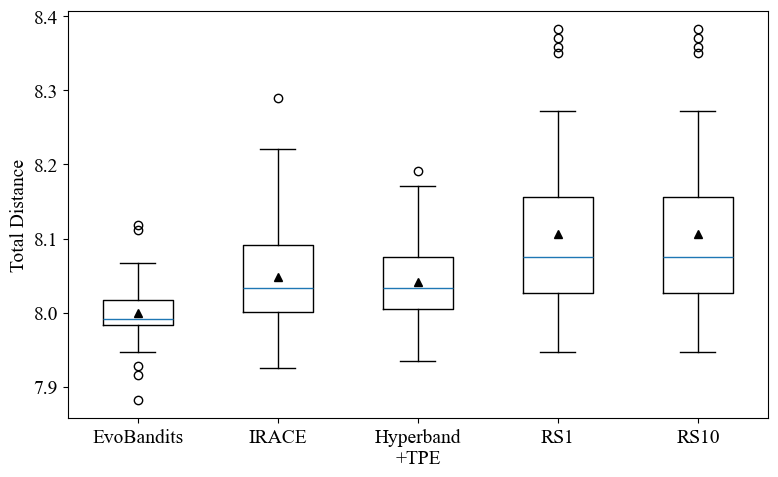

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.boxplot(
    mean_evaluation_data.values(), 
    tick_labels=mean_evaluation_data.keys(), 
    showmeans=True, 
    meanprops={"markerfacecolor":"black", "markeredgecolor":"black"}, 
    medianprops={"color": "C0"}
)
ax.set_ylabel("Total Distance")

plt.tight_layout()
plt.savefig(Path("_plots/06_comparison.pdf"))
plt.show()